# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [79]:
# Import warnings

import warnings

In [80]:
# Import the libraries you will be using for analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [81]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.2.3
pandas version: 2.2.3
matplotlib version: 3.9.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [82]:
# Try loading one file

# df = pd.read_parquet('2023-1.parquet')
# df.info()

df = pd.read_parquet('./trip_records/2023-1.parquet')
df.info()
df.head

FileNotFoundError: [Errno 2] No such file or directory: './trip_records/2023-1.parquet'

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

# Get hour and date 
df['tpep_pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['tpep_pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['tpep_pickup_date'] = pd.to_datetime(df['tpep_pickup_date'])

#Verify the values
print(df[['tpep_pickup_datetime','tpep_pickup_date','tpep_pickup_hour']])


# Initialize  sampled_data to keep appending sampled data of each hour
sampled_data = pd.DataFrame()

# Group by both date and hour, since we need data set for each date and across hours 
grouped = df.groupby(['tpep_pickup_date', 'tpep_pickup_hour'])

# Adding 5% sample to sampled_data
for (date, hour), hour_data in grouped:
    sample = hour_data.sample(frac=0.05, random_state=42)
    sampled_data = pd.concat([sampled_data, sample])
    
print(sampled_data.head(10))
print(sampled_data.shape)
print(df.shape)


        tpep_pickup_datetime tpep_pickup_date  tpep_pickup_hour
0        2023-01-01 00:32:10       2023-01-01                 0
1        2023-01-01 00:55:08       2023-01-01                 0
2        2023-01-01 00:25:04       2023-01-01                 0
3        2023-01-01 00:03:48       2023-01-01                 0
4        2023-01-01 00:10:29       2023-01-01                 0
...                      ...              ...               ...
3066761  2023-01-31 23:58:34       2023-01-31                23
3066762  2023-01-31 23:31:09       2023-01-31                23
3066763  2023-01-31 23:01:05       2023-01-31                23
3066764  2023-01-31 23:40:00       2023-01-31                23
3066765  2023-01-31 23:07:32       2023-01-31                23

[3041714 rows x 3 columns]
         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
80              2  2022-12-31 23:51:30   2022-12-31 23:56:06              1.0   
428             2  2023-01-01 00:07:18   2

In [ ]:
df.tpep_pickup_hour.value_counts()

tpep_pickup_hour
18    214294
17    207902
15    194886
16    194267
19    191289
14    190067
13    177379
12    168642
20    164436
21    160194
11    153084
22    146069
10    142658
9     130288
8     116209
23    113398
7      86313
0      84044
1      59165
6      43410
2      41508
3      27011
5      17724
4      17477
Name: count, dtype: int64

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
dir="/home/hiteshp/Documents/Personal/Upgrad/IITB/EDA_Assignment/Datasets and Dictionary-NYC/trip_records"
if (os.getcwd() == dir):
    print("In the current directory itself:",os.getcwd())
else:
    print("Changing Directoy to trip_records")
    os.chdir(dir)
print("Current Directory :", os.getcwd())

# Need to remove since if we rerun the notebook , it reads the sampled file too 
file_path = '2023-sampled.parquet'
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' has been deleted.")
else:
    print(f"ℹFile '{file_path}' does not exist.")


# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()

# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        print(f"Reading file {file_name}")
        df_temp = pd.read_parquet(file_name)
        # print(f"Columns in file ",df.columns)
        print(f"Intial shape of the file {file_name} :",df_temp.shape)
        # print(f"Columns in the file {file_name} :",df.columns)

      
        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date

            # Iterate through each hour of the selected date

                # Sample 5% of the hourly data randomly

                # add data of this hour to the dataframe

        # Get hour and date 
        df_temp['tpep_pickup_hour'] = df_temp['tpep_pickup_datetime'].dt.hour
        df_temp['tpep_pickup_date'] = df_temp['tpep_pickup_datetime'].dt.date

        #Verify the values
        # print(df[['tpep_pickup_datetime','tpep_pickup_date','tpep_pickup_hour']])

        # Group by both date and hour, since we need data set for each date and across hours 
        grouped = df_temp.groupby(['tpep_pickup_date', 'tpep_pickup_hour'])

        # Adding 5% sample to sampled_datadf.reset_index(drop=True, inplace=True)
        for (date, hour), hour_data in grouped:
            sample = hour_data.sample(frac=0.05, random_state=42)
            sampled_data = pd.concat([sampled_data, sample])
            
        print("Sample data head ",sampled_data.head(10))
        # print(sampled_data.shape)
        print(f"After sampling shape of the file {file_name} :",sampled_data.shape)

        # Concatenate the sampled data of all the dates to a single dataframe
#        df = # we initialised this empty DF earlier
        df= pd.concat([df, sampled_data])
        print(f"Current shape of the file {file_name} after sampling and concatinating : ",df.shape)
        # print(f"After merge, columns in the file {file_name} :",df.columns)


    except Exception as e:
        print(f"Error reading file {file_name}: {e}")
    
    print(f"Shape of the file {file_name} after sampling and concatinating : ",df.shape)
    print()
    

Changing Directoy to trip_records
Current Directory : /home/hiteshp/Documents/Personal/Upgrad/IITB/EDA_Assignment/Datasets and Dictionary-NYC/trip_records
File '2023-sampled.parquet' has been deleted.
Reading file 2023-6.parquet
Intial shape of the file 2023-6.parquet : (3258261, 19)
Sample data head        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
5387         2  2023-03-31 23:59:51   2023-04-01 00:20:33              1.0   
3024         2  2023-03-31 23:27:13   2023-04-01 22:39:00              2.0   
4310         1  2023-04-01 00:58:33   2023-04-01 01:07:03              4.0   
2602         1  2023-04-01 00:10:28   2023-04-01 00:27:17              1.0   
4638         2  2023-04-01 00:54:11   2023-04-01 01:00:52              1.0   
234          1  2023-04-01 00:53:11   2023-04-01 01:04:05              2.0   
1334         2  2023-04-01 00:38:39   2023-04-01 00:52:06              4.0   
4332         2  2023-04-01 00:08:28   2023-04-01 00:38:10              2.

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
# Store the df in csv/parquet
print("Current Directory:", os.getcwd())
df.to_parquet('2023-sampled.parquet')


Current Directory: /home/hiteshp/Documents/Personal/Upgrad/IITB/EDA_Assignment/Datasets and Dictionary-NYC/trip_records


## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [ ]:
# Load the new data file
df_sampled= pd.read_parquet("2023-sampled.parquet")

# Since we have to keep the total entries to around 250,000 to 300,000.
#Considering 12 hours
rows_per_hour = round(300000/24)

# Empty DataFrame to collect sampled data
df = pd.DataFrame()

# Loop through each hour and sample rows
for hour in range(24):
    hour_df = df_sampled[df_sampled['tpep_pickup_hour'] == hour]
    
    # Sample from this hour 
    sample_size = min(rows_per_hour, len(hour_df))
    sample = hour_df.sample(n=sample_size, random_state=42)
    
    df = pd.concat([df, sample])

# Reset index for cleanliness
df.reset_index(drop=True, inplace=True)

# Check final shape and hourly distribution
print("Final dataset shape:", df.shape)
print(df['tpep_pickup_hour'].value_counts().sort_index())




Final dataset shape: (296773, 22)
tpep_pickup_hour
0     12500
1     12500
2     12500
3     12500
4     10637
5     11136
6     12500
7     12500
8     12500
9     12500
10    12500
11    12500
12    12500
13    12500
14    12500
15    12500
16    12500
17    12500
18    12500
19    12500
20    12500
21    12500
22    12500
23    12500
Name: count, dtype: int64


In [ ]:
df.head()
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'tpep_pickup_hour', 'tpep_pickup_date', 'airport_fee'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296773 entries, 0 to 296772
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               296773 non-null  int64         
 1   tpep_pickup_datetime   296773 non-null  datetime64[us]
 2   tpep_dropoff_datetime  296773 non-null  datetime64[us]
 3   passenger_count        283743 non-null  float64       
 4   trip_distance          296773 non-null  float64       
 5   RatecodeID             283743 non-null  float64       
 6   store_and_fwd_flag     283743 non-null  object        
 7   PULocationID           296773 non-null  int64         
 8   DOLocationID           296773 non-null  int64         
 9   payment_type           296773 non-null  int64         
 10  fare_amount            296773 non-null  float64       
 11  extra                  296773 non-null  float64       
 12  mta_tax                296773 non-null  floa

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [ ]:
# Fix the index and drop any columns that are not needed
df.reset_index(drop=True,inplace=True)
df.shape

# df['tolls_amount'].value_counts()
# df['congestion_surcharge'].value_counts()
#df['Airport_fee'].value_counts()

#As per the provided data dictionary and the problem statement dropping the below columns 
# tolls_amount - Already part of total_amount
# store_and_fwd_flag - Better for Technical Analysis but not for Buissness Insights
# extra - No major impact for Buissness Insights
# mta_tax - No major impact for Buissness Insights
# improvement_surcharge - No major impact for Buissness Insights
# tolls_amount - Almost same for all trips ,  0.00     1742598

# Dropping columns that are not relevant to Buissness Insights
columns_to_drop = ['tolls_amount','store_and_fwd_flag','extra','mta_tax','improvement_surcharge','tolls_amount']
df.drop(columns=columns_to_drop, inplace=True)
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'tip_amount',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'tpep_pickup_hour', 'tpep_pickup_date', 'airport_fee'],
      dtype='object')

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [ ]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'tip_amount',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'tpep_pickup_hour', 'tpep_pickup_date', 'airport_fee'],
      dtype='object')

In [ ]:
# Combine the two airport fee columns

# Check for the existing columns and find similar column names to be merged
df.columns

#check sample values from both columns
print(df[['Airport_fee','airport_fee']])

# Just combining 2 columns may provide inconsistent data
# It is possible that airport_fee may have value higher than Airport_fee and skipping this values may provide incorrect analysis as we need to consider maximum possible fees as per data
df['Airport_fee'] = df['Airport_fee'].combine(df['airport_fee'],max)

# Dropping duplicate column airport_fee
df.drop(columns=['airport_fee'], inplace=True)

# Verify is the column is being dropped
df.columns

        Airport_fee  airport_fee
0               0.0          NaN
1               0.0          NaN
2               0.0          NaN
3               0.0          NaN
4               0.0          NaN
...             ...          ...
296768          0.0          NaN
296769          0.0          NaN
296770          0.0          NaN
296771          0.0          NaN
296772          0.0          NaN

[296773 rows x 2 columns]


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'tip_amount',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'tpep_pickup_hour', 'tpep_pickup_date'],
      dtype='object')

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [ ]:
# check where values of fare amount are negative
negative_fare= df[df['fare_amount'] < 0]
negative_fare

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, tip_amount, total_amount, congestion_surcharge, Airport_fee, tpep_pickup_hour, tpep_pickup_date]
Index: []

Did you notice something different in the `RatecodeID` column for above records?

In [ ]:
# Analyse RatecodeID for the negative fare amounts
negative_fare['RatecodeID']

Series([], Name: RatecodeID, dtype: float64)

In [ ]:
# Find which columns have negative values

# df.info()

# To store columns which have negative values
negative_columns = []

# First we select only the columns with numerical values or it gives exception with values other than numeric 

for column in df.select_dtypes(include='number').columns:
    negative_values = df[df[column] < 0]
    if len(negative_values) > 0:
        print("Negative values exist in column:", column)
        negative_columns.append(column)
        
print("Final list of negative columns : ",negative_columns)
    


Negative values exist in column: total_amount
Negative values exist in column: congestion_surcharge
Negative values exist in column: Airport_fee
Final list of negative columns :  ['total_amount', 'congestion_surcharge', 'Airport_fee']


In [ ]:
# fix these negative values

# On the basis of initial findings
# Since rest of the columns may have meaningful data which can be used for analysis, we should keep the entries by updating negative values to 0.

for column in negative_columns:
    print(f"Shape of {column} : ", df[df[column] < 0].shape)

df[df['total_amount'] < 0].shape

# However since the count is low and it wont poses any significant impact on the analysis, dropping these rows.
# Looping through each column and dropping rows where values are negative
# Shape of total_amount :  (87, 14)
# Shape of Airport_fee :  (16, 14)

for column in negative_columns:
    df = df[~(df[column] < 0)]
    



Shape of total_amount :  (14, 16)
Shape of congestion_surcharge :  (11, 16)
Shape of Airport_fee :  (1, 16)


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [ ]:
# Find the proportion of missing values in each column

# df.isnull().sum()

total_count=df.shape[0]

# Loop through each column to find the proportion of missing values
for column in df.columns:
    missing_count = df[column].isnull().sum()
    missing_percentage= round((missing_count/total_count)*100,2)        
    print(f"Proportion of missing values in {column} : {missing_percentage}%")


Proportion of missing values in VendorID : 0.0%
Proportion of missing values in tpep_pickup_datetime : 0.0%
Proportion of missing values in tpep_dropoff_datetime : 0.0%
Proportion of missing values in passenger_count : 4.39%
Proportion of missing values in trip_distance : 0.0%
Proportion of missing values in RatecodeID : 4.39%
Proportion of missing values in PULocationID : 0.0%
Proportion of missing values in DOLocationID : 0.0%
Proportion of missing values in payment_type : 0.0%
Proportion of missing values in fare_amount : 0.0%
Proportion of missing values in tip_amount : 0.0%
Proportion of missing values in total_amount : 0.0%
Proportion of missing values in congestion_surcharge : 4.39%
Proportion of missing values in Airport_fee : 12.29%
Proportion of missing values in tpep_pickup_hour : 0.0%
Proportion of missing values in tpep_pickup_date : 0.0%


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [ ]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'

# Get rows where any of columns has null values
print(df[df.isnull().any(axis=1)].head())

# =========================================
# Existing code which has been rewritten as function
# =========================================
# print("Get count by number of passengers : \n",df['passenger_count'].value_counts())

# print("Missing values before Imputation : ",df['passenger_count'].isnull().sum())

# # Since we need to Impute NAN values in 'passenger_count' i am proceeding with below assumptions.
# # IF we used default value such as 1 , it will always represent solo rider , thus implying more number of solo riders

# mean_value = df['passenger_count'].mean()
# mode_value = df['passenger_count'].mode()[0]

# print(f"Mean passenger count : {mean_value}")
# print(f"Mode passenger count : {mode_value}")

# # Hence proceeding with mode as it would give me the most frequent number of passengers in the cab , since mean gives fractional values which is not realistically possible
# df['passenger_count'] = df['passenger_count'].fillna(mode_value)

# # Verification if the values have been added
# print("Missing values after  Imputation : ",df['passenger_count'].isnull().sum())
# print("Check if Mode values have been added : \n",df['passenger_count'].value_counts())
# =========================================

# Note : Initially i have replicated this code for all the 3 but later rewritten it as generic function
# Function is used since same has been replicated for RatecodeID,congestion_surcharge

def impute_column(df, column_name):
    print(f"\nImputing missing values in '{column_name}'")

    # Check missing values before Imputing
    print("Get initial count : \n",df[column_name].value_counts())
    missing_before = df[column_name].isnull().sum()
    print(f"Missing values before imputation: {missing_before}")

    # Calculate mean and mode
    # Since we need to Impute NAN values, proceeding with below assumptions.
    # IF we used default value, it may implies more entires for that value
    mean_value = df[column_name].mean()
    mode_value = df[column_name].mode()[0]

    print(f"Mean of {column_name}: {mean_value}")
    print(f"Mode of {column_name}: {mode_value}")

    # Impute using mode
    # Proceeding with mode as it would give me the most frequent count , since mean gives fractional values which is not realistically possible

    df[column_name] = df[column_name].fillna(mode_value)

    # Check missing values after Imputation
    missing_after = df[column_name].isnull().sum()
    print(f"Missing values after imputation: {missing_after}")

    # Show updated value counts
    print(f"Value counts after imputation:\n{df[column_name].value_counts()}")


# Since we need to Impute NAN values in 'passenger_count', i am proceeding with below assumptions.
# IF we used default value such as 1 , it will always represent solo rider , thus implying more number of solo riders
# Hence proceeding with mode as it would give me the most frequent number of passengers in the cab , since mean gives fractional values which is not realistically possible

impute_column(df, 'passenger_count')





    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
5          2  2023-01-22 00:32:09   2023-01-22 00:53:14              1.0   
6          2  2023-01-27 00:07:45   2023-01-27 00:16:02              1.0   
7          1  2023-01-15 00:15:21   2023-01-15 00:34:39              1.0   
15         2  2023-01-22 00:45:02   2023-01-22 01:03:58              2.0   
37         2  2023-01-15 00:01:53   2023-01-15 00:03:47              1.0   

    trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
5            3.75         1.0            48           141             1   
6            1.51         1.0           234           144             1   
7            5.80         1.0           113            41             1   
15           5.51         1.0            79           239             1   
37           0.29         1.0           249           249             1   

    fare_amount  tip_amount  total_amount  congestion_surcharge  Airport_fee  \
5          2

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [ ]:
# Fix missing values in 'RatecodeID'

# =========================================
# Existing code which has been rewritten as function
# =========================================
# print("Get count by number of rate code : \n",df['RatecodeID'].value_counts())
# print("Missing values before Imputation : ",df['RatecodeID'].isnull().sum())

# # Since we need to Impute NAN values in 'RatecodeID' i am proceeding with below assumptions.
# # IF we used default value such as 1 , it will always represent Standard rate, thus implying more number of rate codes of type Standard rate

# mean_value = df['RatecodeID'].mean()
# mode_value = df['RatecodeID'].mode()[0]

# print(f"Mean passenger count : {mean_value}")
# print(f"Mode passenger count : {mode_value}")

# # Hence proceeding with mode as it would give me the most frequent number of rate codes at the end of the trip, since mean gives fractional values which is not realistically possible
# df['RatecodeID'] = df['RatecodeID'].fillna(mode_value)

# # Verification if the values have been added
# print("Missing values after  Imputation : ",df['RatecodeID'].isnull().sum())
# print("Check if Mode values have been added : \n",df['RatecodeID'].value_counts())
# =========================================


# Since we need to Impute NAN values in 'RatecodeID' i am proceeding with below assumptions.
# IF we used default value such as 1 , it will always represent Standard rate, thus implying more number of rate codes of type Standard rate
# Hence proceeding with mode as it would give me the most frequent number of rate codes at the end of the trip, since mean gives fractional values which is not realistically possible

impute_column(df, 'RatecodeID')



Imputing missing values in 'RatecodeID'
Get initial count : 
 RatecodeID
1.0     265893
2.0      11499
99.0      2215
5.0       2201
3.0       1270
4.0        650
6.0          1
Name: count, dtype: int64
Missing values before imputation: 13030
Mean of RatecodeID: 1.8524613275343726
Mode of RatecodeID: 1.0
Missing values after imputation: 0
Value counts after imputation:
RatecodeID
1.0     278923
2.0      11499
99.0      2215
5.0       2201
3.0       1270
4.0        650
6.0          1
Name: count, dtype: int64


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [ ]:
# handle null values in congestion_surcharge

# Since we need to Impute NAN values in 'congestion_surcharge' i am proceeding with below assumptions.
# IF we used default value such as 1 , it will always represent Standard rate, thus implying more number of rate codes of type Standard rate
# Hence proceeding with mode as it would give me the most frequent number of rate codes at the end of the trip, since mean gives fractional values which is not realistically possible

impute_column(df, 'congestion_surcharge')



Imputing missing values in 'congestion_surcharge'
Get initial count : 
 congestion_surcharge
2.5    259726
0.0     24003
Name: count, dtype: int64
Missing values before imputation: 13030
Mean of congestion_surcharge: 2.2885041712338183
Mode of congestion_surcharge: 2.5
Missing values after imputation: 0
Value counts after imputation:
congestion_surcharge
2.5    272756
0.0     24003
Name: count, dtype: int64


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [ ]:
# Handle any remaining missing values

#Get list of all the Null columns
null_columns = df.columns[df.isnull().any()].tolist()
print("Columns with missing values:", null_columns)

# Since we need to Impute NAN values, i am proceeding with below assumptions.
# Impute using mode
# Proceeding with mode as it would give me the most frequent count , since mean gives fractional values which is not realistically possible
for column in null_columns:
    impute_column(df, column)


Columns with missing values: ['Airport_fee']

Imputing missing values in 'Airport_fee'
Get initial count : 
 Airport_fee
0.00    238547
1.75     17695
1.25      4052
Name: count, dtype: int64
Missing values before imputation: 36465
Mean of Airport_fee: 0.13842520380800172
Mode of Airport_fee: 0.0
Missing values after imputation: 0
Value counts after imputation:
Airport_fee
0.00    275012
1.75     17695
1.25      4052
Name: count, dtype: int64


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

            VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  296759.000000                      296759                      296759   
mean        1.733073  2023-07-02 16:19:40.908656  2023-07-02 16:36:31.113661   
min         1.000000         2023-01-01 00:00:57         2023-01-01 00:13:27   
25%         1.000000         2023-04-02 03:18:05         2023-04-02 03:29:24   
50%         2.000000         2023-06-28 05:58:31         2023-06-28 06:24:12   
75%         2.000000  2023-10-06 19:56:08.500000         2023-10-06 20:14:47   
max         6.000000         2023-12-31 23:54:28         2024-01-01 12:29:40   
std         0.449383                         NaN                         NaN   

       passenger_count  trip_distance     RatecodeID   PULocationID  \
count    296759.000000  296759.000000  296759.000000  296759.000000   
mean          1.349941       4.551997       1.815032     162.744321   
min           0.000000       0.000000       1.000000       1.00000

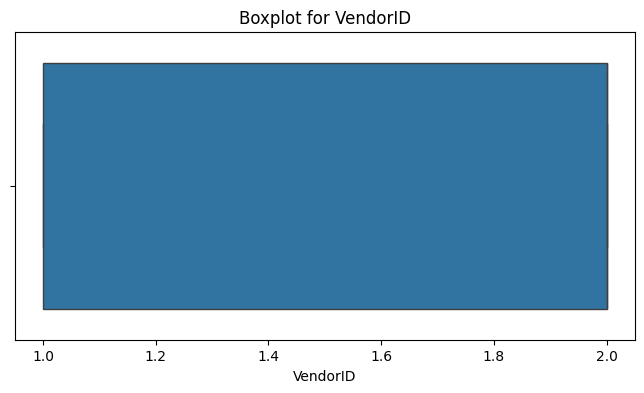

Initial Value counts for column passenger_count :  passenger_count
1.0    227516
2.0     42090
3.0     10298
4.0      5994
0.0      4487
5.0      3747
6.0      2529
7.0         2
8.0         2
9.0         1
Name: count, dtype: int64
Removing Outliers from column {column}
Initial description of passenger_count: count    296666.000000
mean          1.350050
std           0.878153
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: passenger_count, dtype: float64
After outliers, Value counts for column passenger_count :  passenger_count
1.0    227516
Name: count, dtype: int64
Plotting Box plot for column {column}


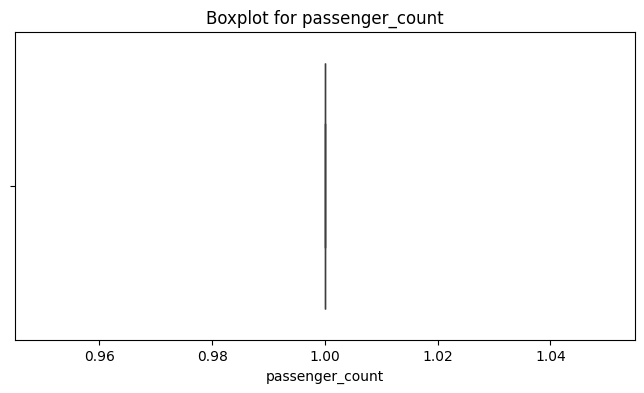

Initial Value counts for column trip_distance :  trip_distance
0.00        6226
1.10        2887
1.00        2880
0.80        2869
0.90        2825
            ... 
37.28          1
39.00          1
22562.67       1
29.21          1
20.87          1
Name: count, Length: 2825, dtype: int64
Removing Outliers from column {column}
Initial description of trip_distance: count    227516.000000
mean          4.658737
std         198.399370
min           0.000000
25%           1.060000
50%           1.830000
75%           3.630000
max       56823.800000
Name: trip_distance, dtype: float64
After outliers, Value counts for column trip_distance :  trip_distance
0.00    6226
1.10    2887
1.00    2880
0.80    2869
0.90    2825
        ... 
6.98      21
6.91      21
7.31      21
7.39      19
7.23      18
Name: count, Length: 749, dtype: int64
Plotting Box plot for column {column}


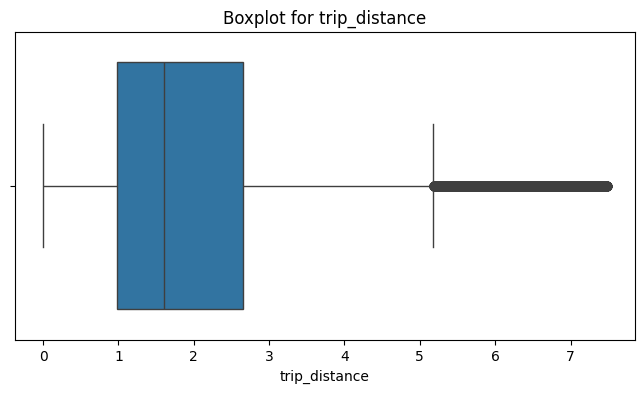

Initial Value counts for column RatecodeID :  RatecodeID
1.0     195371
99.0      1293
5.0       1145
2.0        351
3.0         66
4.0         42
6.0          1
Name: count, dtype: int64
Removing Outliers from column {column}
Initial description of RatecodeID: count    198269.000000
mean          1.665298
std           7.892222
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          99.000000
Name: RatecodeID, dtype: float64
After outliers, Value counts for column RatecodeID :  RatecodeID
1.0    195371
Name: count, dtype: int64
Plotting Box plot for column {column}


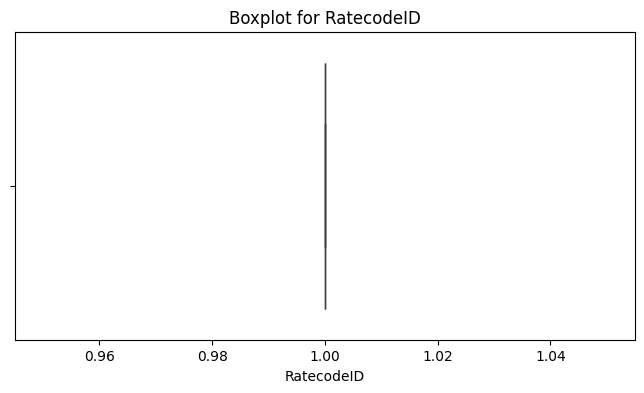

Initial Value counts for column PULocationID :  PULocationID
237    8850
236    8371
186    7957
161    7924
79     7201
       ... 
20        1
184       1
9         1
81        1
245       1
Name: count, Length: 219, dtype: int64
Removing Outliers from column {column}
Initial description of PULocationID: count    195371.000000
mean        165.949348
std          66.202863
min           1.000000
25%         114.000000
50%         162.000000
75%         234.000000
max         265.000000
Name: PULocationID, dtype: float64
After outliers, Value counts for column PULocationID :  PULocationID
237    8850
236    8371
186    7957
161    7924
79     7201
       ... 
20        1
184       1
9         1
81        1
245       1
Name: count, Length: 219, dtype: int64
Plotting Box plot for column {column}


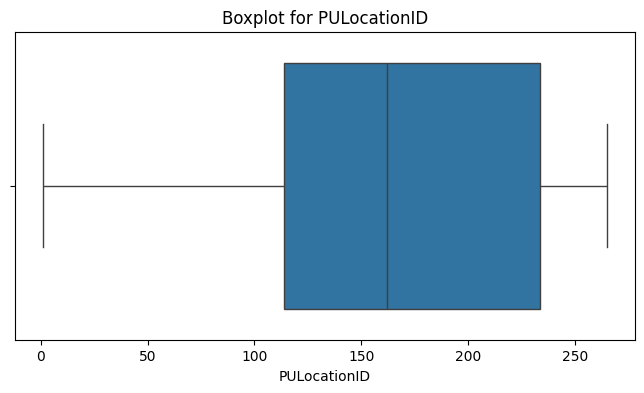

Initial Value counts for column DOLocationID :  DOLocationID
161    8437
236    8370
237    8147
170    6343
162    6069
       ... 
19        1
200       1
150       1
2         1
96        1
Name: count, Length: 231, dtype: int64
Removing Outliers from column {column}
Initial description of DOLocationID: count    195371.000000
mean        163.919220
std          69.438503
min           1.000000
25%         113.000000
50%         162.000000
75%         234.000000
max         265.000000
Name: DOLocationID, dtype: float64
After outliers, Value counts for column DOLocationID :  DOLocationID
161    8437
236    8370
237    8147
170    6343
162    6069
       ... 
19        1
200       1
150       1
2         1
96        1
Name: count, Length: 231, dtype: int64
Plotting Box plot for column {column}


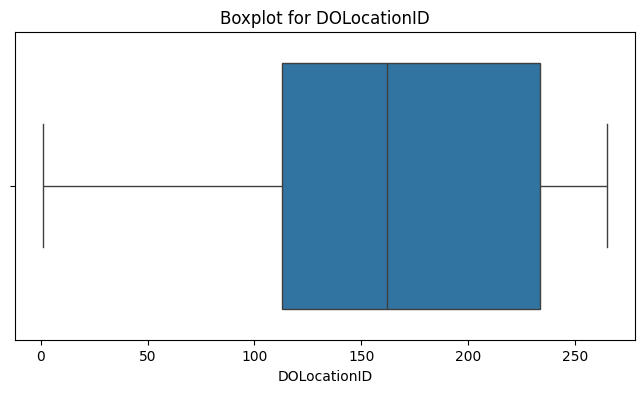

Initial Value counts for column payment_type :  payment_type
1    151458
2     30607
0     10686
4      1596
3      1024
Name: count, dtype: int64
Removing Outliers from column {column}
Initial description of payment_type: count    195371.000000
mean          1.136955
std           0.535806
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: payment_type, dtype: float64
After outliers, Value counts for column payment_type :  payment_type
1    151458
Name: count, dtype: int64
Plotting Box plot for column {column}


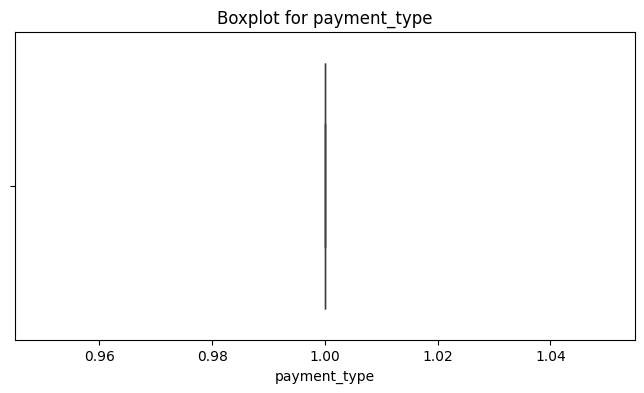

Initial Value counts for column fare_amount :  fare_amount
9.3     8348
8.6     8227
7.9     8027
10.0    8007
10.7    7722
        ... 
13.3       1
57.2       1
37.2       1
29.4       1
63.2       1
Name: count, Length: 191, dtype: int64
Removing Outliers from column {column}
Initial description of fare_amount: count    151458.000000
mean         13.787281
std           6.962223
min           0.000000
25%           8.600000
50%          12.100000
75%          17.000000
max         108.700000
Name: fare_amount, dtype: float64
After outliers, Value counts for column fare_amount :  fare_amount
9.3     8348
8.6     8227
7.9     8027
10.0    8007
10.7    7722
        ... 
23.7       1
7.0        1
6.0        1
13.3       1
29.4       1
Name: count, Length: 88, dtype: int64
Plotting Box plot for column {column}


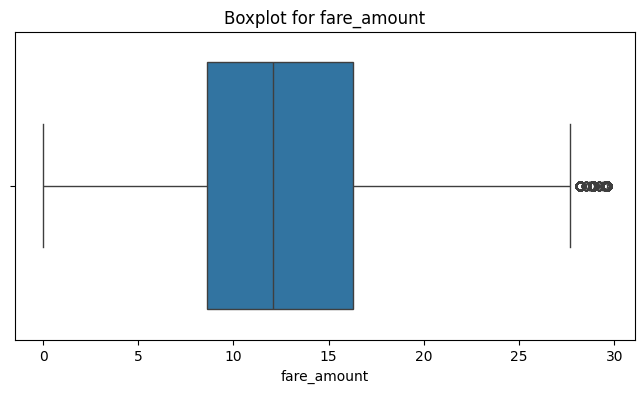

Initial Value counts for column tip_amount :  tip_amount
2.00      10833
1.00       9274
0.00       6155
3.00       5692
2.80       2442
          ...  
10.49         1
0.14          1
15.15         1
26.90         1
202.00        1
Name: count, Length: 949, dtype: int64
Removing Outliers from column {column}
Initial description of tip_amount: count    146409.000000
mean          3.160370
std           1.992228
min           0.000000
25%           2.000000
50%           3.000000
75%           4.020000
max         202.000000
Name: tip_amount, dtype: float64
After outliers, Value counts for column tip_amount :  tip_amount
2.00    10833
1.00     9274
0.00     6155
3.00     5692
2.80     2442
        ...  
4.86        1
2.71        1
1.13        1
6.74        1
5.81        1
Name: count, Length: 644, dtype: int64
Plotting Box plot for column {column}


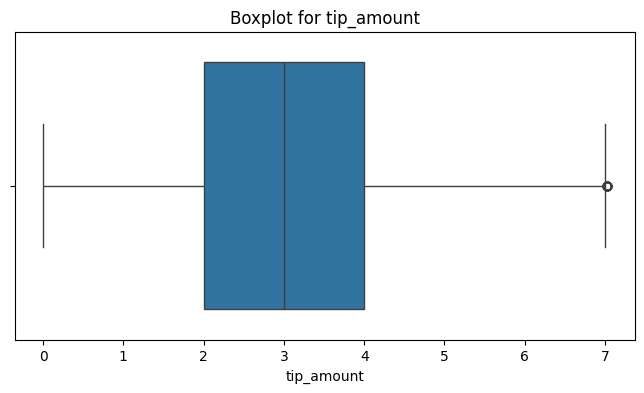

Initial Value counts for column total_amount :  total_amount
16.80    2224
21.00    1973
18.00    1949
12.60    1861
15.96    1636
         ... 
16.09       1
19.36       1
23.57       1
15.06       1
13.38       1
Name: count, Length: 2083, dtype: int64
Removing Outliers from column {column}
Initial description of total_amount: count    143710.000000
mean         20.636024
std           6.804731
min           0.000000
25%          15.480000
50%          19.320000
75%          24.720000
max          79.000000
Name: total_amount, dtype: float64
After outliers, Value counts for column total_amount :  total_amount
16.80    2224
21.00    1973
18.00    1949
12.60    1861
15.96    1636
         ... 
19.74       1
19.22       1
28.78       1
22.13       1
20.74       1
Name: count, Length: 1888, dtype: int64
Plotting Box plot for column {column}


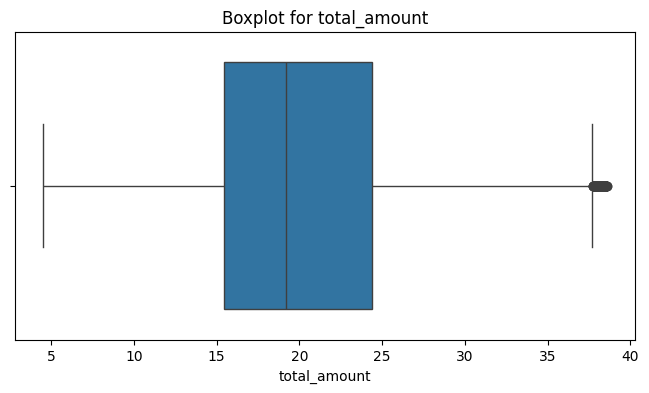

Initial Value counts for column congestion_surcharge :  congestion_surcharge
2.5    138249
0.0      3389
Name: count, dtype: int64
Removing Outliers from column {column}
Initial description of congestion_surcharge: count    141638.000000
mean          2.440182
std           0.382057
min           0.000000
25%           2.500000
50%           2.500000
75%           2.500000
max           2.500000
Name: congestion_surcharge, dtype: float64
After outliers, Value counts for column congestion_surcharge :  congestion_surcharge
2.5    138249
Name: count, dtype: int64
Plotting Box plot for column {column}


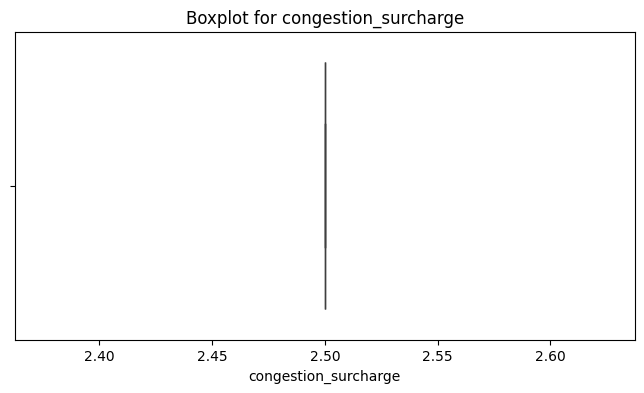

Initial Value counts for column Airport_fee :  Airport_fee
0.00    138225
1.75        19
1.25         5
Name: count, dtype: int64
Removing Outliers from column {column}
Initial description of Airport_fee: count    138249.000000
mean          0.000286
std           0.021848
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.750000
Name: Airport_fee, dtype: float64
After outliers, Value counts for column Airport_fee :  Airport_fee
0.0    138225
Name: count, dtype: int64
Plotting Box plot for column {column}


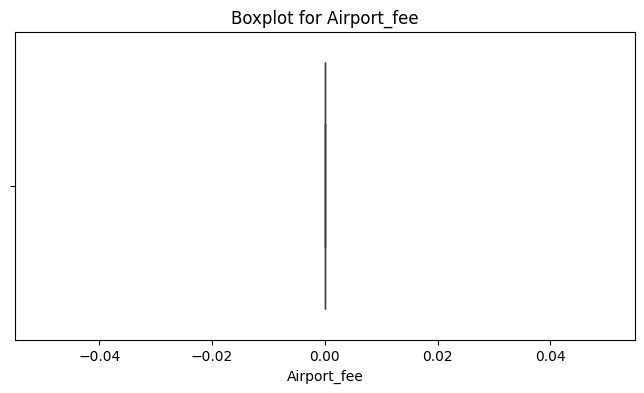

Initial Value counts for column tpep_pickup_hour :  tpep_pickup_hour
8     6854
7     6626
9     6497
19    6249
18    6216
20    6214
2     6031
11    6028
17    6008
10    5957
1     5922
21    5907
22    5853
13    5766
12    5739
6     5733
3     5648
14    5638
16    5627
0     5538
15    5467
23    5424
5     3708
4     3575
Name: count, dtype: int64
Removing Outliers from column {column}
Initial description of tpep_pickup_hour: count    138225.000000
mean         11.699230
std           6.861778
min           0.000000
25%           6.000000
50%          12.000000
75%          18.000000
max          23.000000
Name: tpep_pickup_hour, dtype: float64
After outliers, Value counts for column tpep_pickup_hour :  tpep_pickup_hour
8     6854
7     6626
9     6497
19    6249
18    6216
20    6214
2     6031
11    6028
17    6008
10    5957
1     5922
21    5907
22    5853
13    5766
12    5739
6     5733
3     5648
14    5638
16    5627
0     5538
15    5467
23    5424
5     3708
4     35

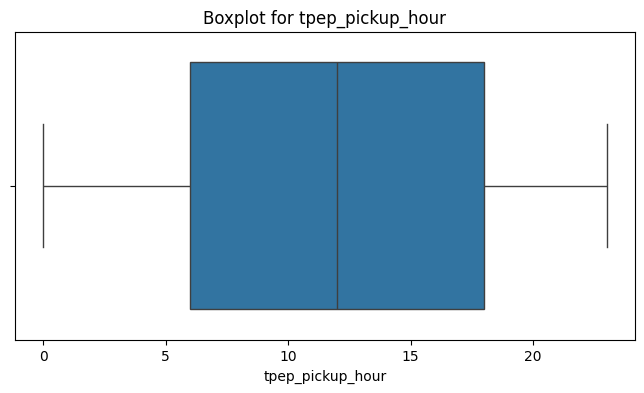

In [ ]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

# Describe the data and check if there are any potential outliers present
print(df.describe())

# Check for potential out of place values in various columns

# A generic function to remove outliers in the columns
# Added type , since it is used in 2.3.1
def remove_outliers(df, column,outlier_type="both"):
    # Print the initial description of the column
    print(f"Initial description of {column}:",df[column].describe())
    
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Filter the data to remove outliers
    if outlier_type=="upper":
        df_filtered = df[df[column] <= upper_limit]
    else:
        df_filtered = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]  
    
    return df_filtered

# BoxPlot to get clear picture if there are any outliers 
def boxplot_column(df, column):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot for {column}")
    plt.show()


df =  df.copy()

# print(df['passenger_count'].value_counts())
# df = df[~(df['passenger_count'] <1)]
# print(df['passenger_count'].value_counts())
# df = df[~(df['passenger_count'] > 4)]
# print(df['passenger_count'].value_counts())
# df = remove_outliers(df, 'passenger_count')
# df.describe()
# boxplot_column(df, 'passenger_count')
# boxplot_column(df, 'passenger_count')



numeric_columns = df.select_dtypes(include='number').columns.tolist()
# numeric_columns = ['passenger_count']
for column in numeric_columns:
    print(f"Initial Value counts for column {column} : ",df[column].value_counts())
    print("Removing Outliers from column {column}")
    df = remove_outliers(df, column)
    print(f"After outliers, Value counts for column {column} : ",df[column].value_counts())
    print("Plotting Box plot for column {column}")
    boxplot_column(df, column)

# Outlier columns
    # passenger_count
    # trip_distance
    # RatecodeID
    # payment_type
    # fare_amount
    # tip_amount
    # total_amount
    # congestion_surcharge
    # Airport_fee

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

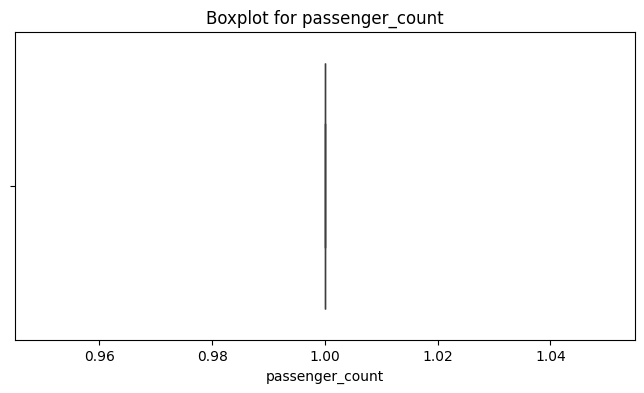

In [ ]:
# remove passenger_count > 6

df = df[~(df['passenger_count'] > 6)]
boxplot_column(df, 'passenger_count')

Initial Value counts for column VendorID :  VendorID
2    102890
1     35335
Name: count, dtype: int64
Removing Outliers from column {column}


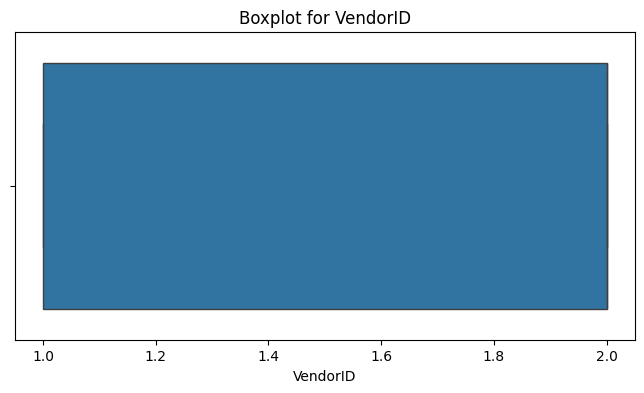

Initial description of VendorID: count    138225.000000
mean          1.744366
std           0.436219
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: VendorID, dtype: float64
After outliers, Value counts for column VendorID :  VendorID
2    102890
1     35335
Name: count, dtype: int64
Plotting Box plot for column {column}


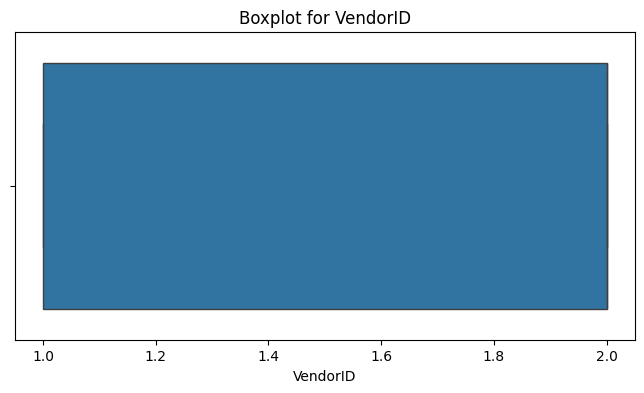

Initial Value counts for column passenger_count :  passenger_count
1.0    138225
Name: count, dtype: int64
Removing Outliers from column {column}


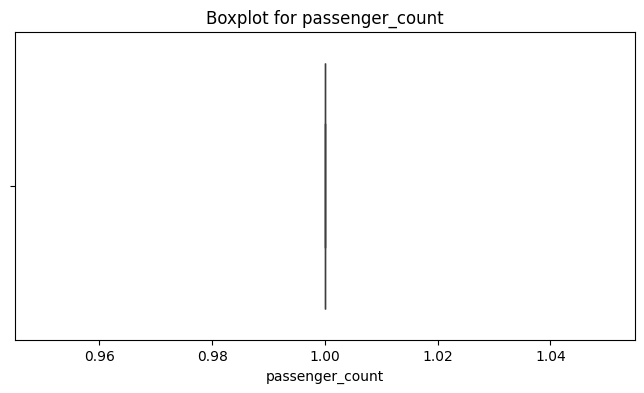

Initial description of passenger_count: count    138225.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: passenger_count, dtype: float64
After outliers, Value counts for column passenger_count :  passenger_count
1.0    138225
Name: count, dtype: int64
Plotting Box plot for column {column}


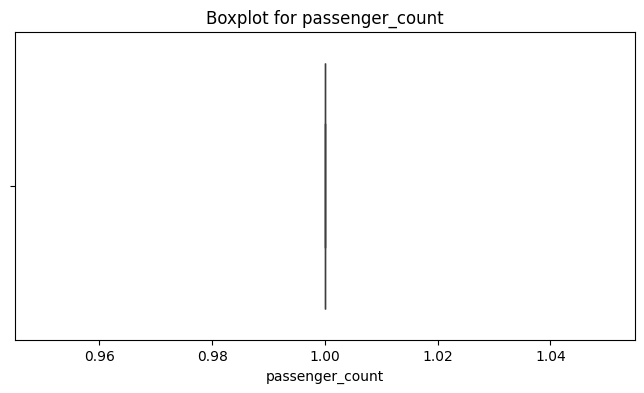

Initial Value counts for column trip_distance :  trip_distance
1.10    2274
1.00    2210
0.90    2181
0.80    2178
1.20    2087
        ... 
6.58       1
6.89       1
6.92       1
6.64       1
6.67       1
Name: count, Length: 703, dtype: int64
Removing Outliers from column {column}


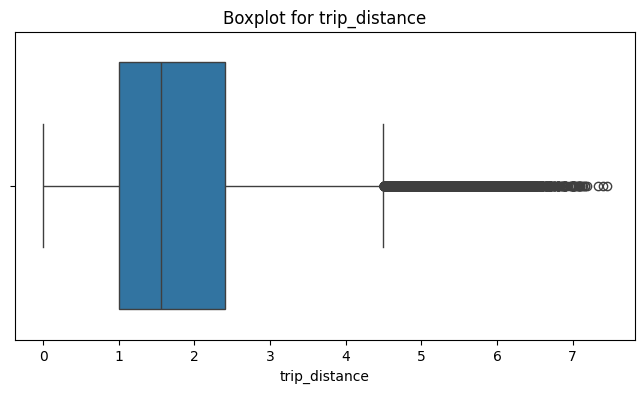

Initial description of trip_distance: count    138225.000000
mean          1.842662
std           1.138035
min           0.000000
25%           1.000000
50%           1.560000
75%           2.400000
max           7.450000
Name: trip_distance, dtype: float64
After outliers, Value counts for column trip_distance :  trip_distance
1.10    2274
1.00    2210
0.90    2181
0.80    2178
1.20    2087
        ... 
0.05       5
0.07       5
0.01       5
0.09       4
0.04       4
Name: count, Length: 451, dtype: int64
Plotting Box plot for column {column}


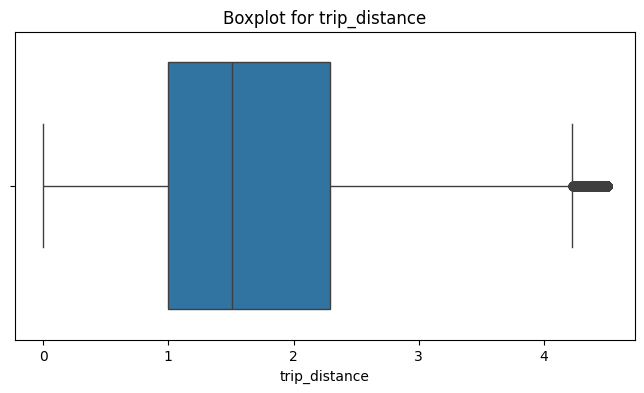

Initial Value counts for column RatecodeID :  RatecodeID
1.0    133416
Name: count, dtype: int64
Removing Outliers from column {column}


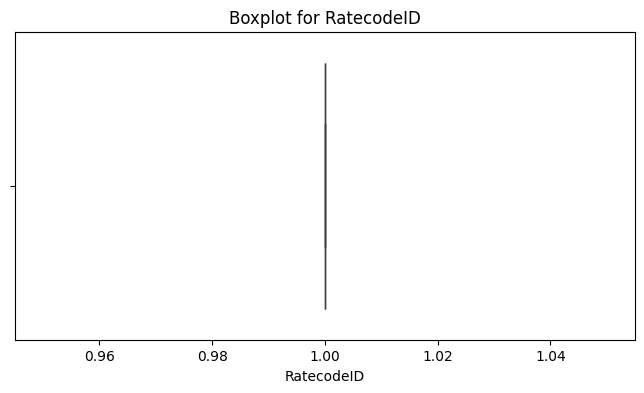

Initial description of RatecodeID: count    133416.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: RatecodeID, dtype: float64
After outliers, Value counts for column RatecodeID :  RatecodeID
1.0    133416
Name: count, dtype: int64
Plotting Box plot for column {column}


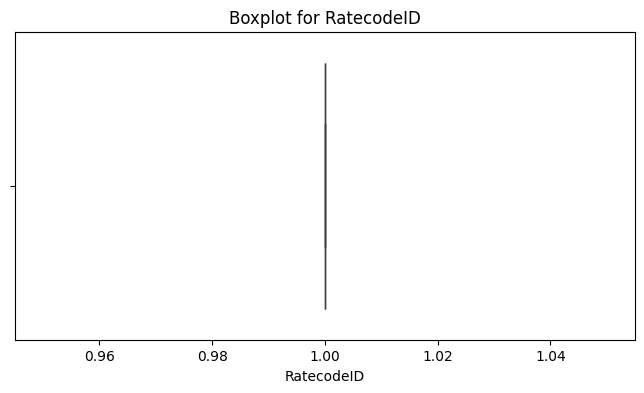

Initial Value counts for column PULocationID :  PULocationID
237    6846
236    6386
161    5956
186    5837
162    5270
       ... 
37        1
80        1
34        1
168       1
101       1
Name: count, Length: 84, dtype: int64
Removing Outliers from column {column}


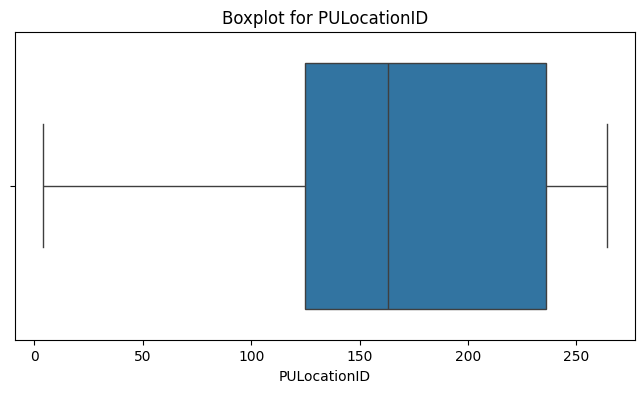

Initial description of PULocationID: count    133416.000000
mean        168.998666
std          64.812132
min           4.000000
25%         125.000000
50%         163.000000
75%         236.000000
max         264.000000
Name: PULocationID, dtype: float64
After outliers, Value counts for column PULocationID :  PULocationID
237    6846
236    6386
161    5956
186    5837
162    5270
       ... 
37        1
80        1
34        1
168       1
101       1
Name: count, Length: 84, dtype: int64
Plotting Box plot for column {column}


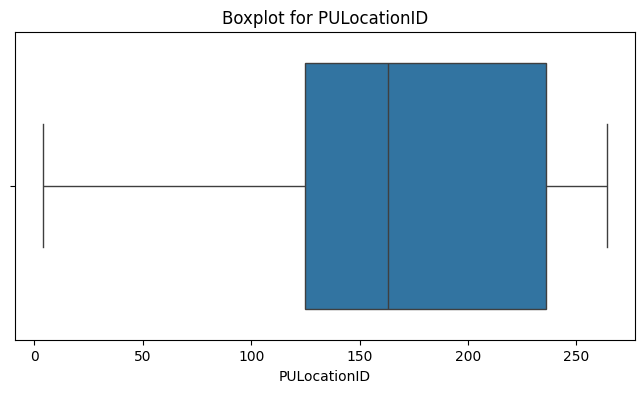

Initial Value counts for column DOLocationID :  DOLocationID
161    6417
236    6326
237    6291
170    4880
162    4662
       ... 
192       1
101       1
198       1
83        1
157       1
Name: count, Length: 110, dtype: int64
Removing Outliers from column {column}


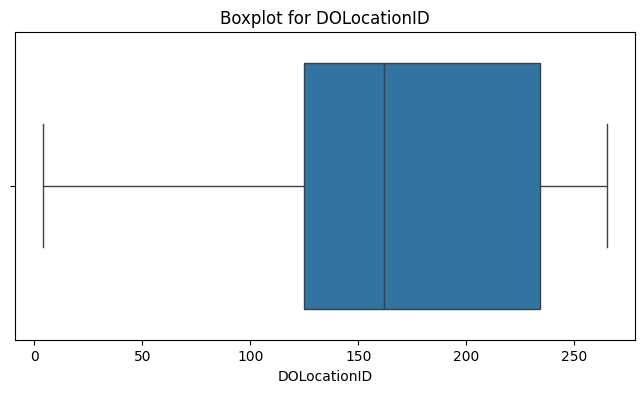

Initial description of DOLocationID: count    133416.000000
mean        167.408512
std          67.087869
min           4.000000
25%         125.000000
50%         162.000000
75%         234.000000
max         265.000000
Name: DOLocationID, dtype: float64
After outliers, Value counts for column DOLocationID :  DOLocationID
161    6417
236    6326
237    6291
170    4880
162    4662
       ... 
192       1
101       1
198       1
83        1
157       1
Name: count, Length: 110, dtype: int64
Plotting Box plot for column {column}


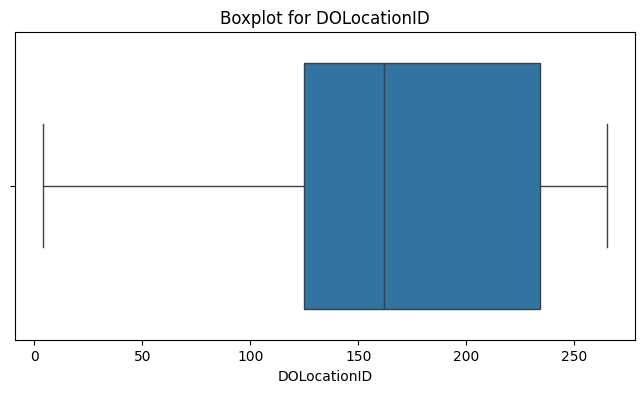

Initial Value counts for column payment_type :  payment_type
1    133416
Name: count, dtype: int64
Removing Outliers from column {column}


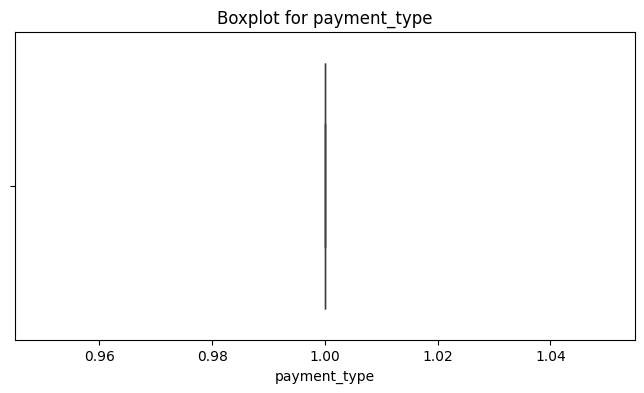

Initial description of payment_type: count    133416.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: payment_type, dtype: float64
After outliers, Value counts for column payment_type :  payment_type
1    133416
Name: count, dtype: int64
Plotting Box plot for column {column}


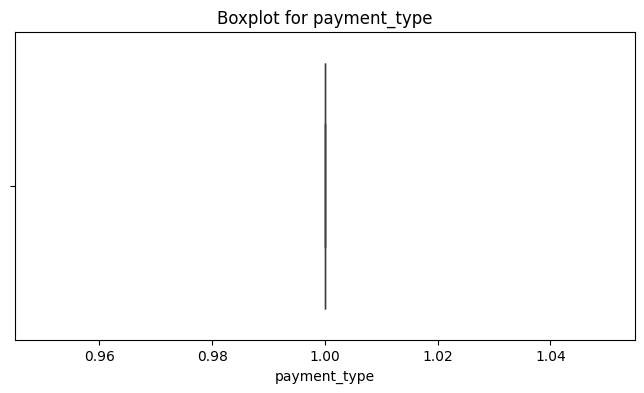

Initial Value counts for column fare_amount :  fare_amount
9.30     8168
8.60     8050
10.00    7825
7.90     7813
10.70    7572
7.20     7388
11.40    7112
12.10    6613
6.50     6440
12.80    6166
13.50    5751
14.20    5264
5.80     5172
14.90    4906
15.60    4340
16.30    3988
17.00    3682
17.70    3260
5.10     3209
18.40    2996
19.10    2706
19.80    2277
20.50    2102
21.20    1851
21.90    1514
4.40     1454
22.60    1205
23.30     982
24.00     870
24.70     630
25.40     536
26.10     372
3.70      369
26.80     297
27.50     207
3.00      112
28.20      84
28.90      67
29.60      38
5.50        5
9.50        4
7.50        2
14.00       2
12.50       2
12.00       2
13.00       1
15.00       1
5.35        1
8.00        1
9.10        1
6.80        1
21.00       1
26.50       1
7.00        1
6.00        1
13.30       1
Name: count, dtype: int64
Removing Outliers from column {column}


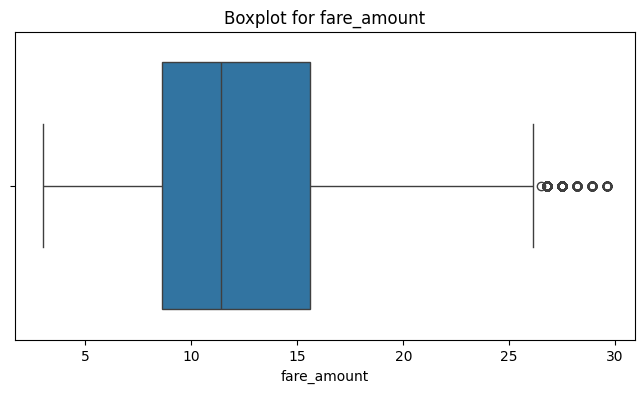

Initial description of fare_amount: count    133416.000000
mean         12.223756
std           4.936809
min           3.000000
25%           8.600000
50%          11.400000
75%          15.600000
max          29.600000
Name: fare_amount, dtype: float64
After outliers, Value counts for column fare_amount :  fare_amount
9.30     8168
8.60     8050
10.00    7825
7.90     7813
10.70    7572
7.20     7388
11.40    7112
12.10    6613
6.50     6440
12.80    6166
13.50    5751
14.20    5264
5.80     5172
14.90    4906
15.60    4340
16.30    3988
17.00    3682
17.70    3260
5.10     3209
18.40    2996
19.10    2706
19.80    2277
20.50    2102
21.20    1851
21.90    1514
4.40     1454
22.60    1205
23.30     982
24.00     870
24.70     630
25.40     536
26.10     372
3.70      369
3.00      112
5.50        5
9.50        4
12.00       2
14.00       2
7.50        2
12.50       2
5.35        1
15.00       1
8.00        1
13.00       1
9.10        1
6.80        1
21.00       1
7.00        1
6.00   

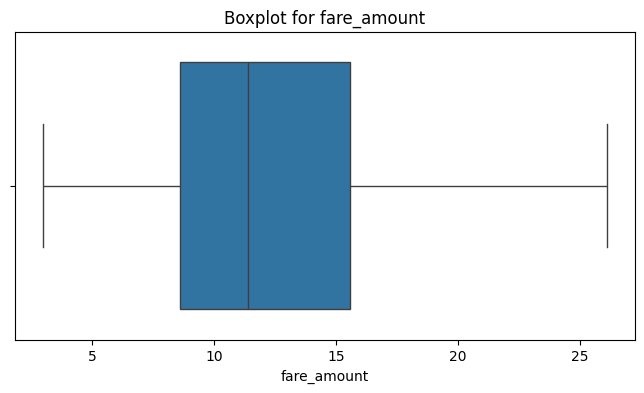

Initial Value counts for column tip_amount :  tip_amount
2.00    10109
1.00     8868
0.00     5193
3.00     5149
2.80     2421
        ...  
2.29        1
4.44        1
1.13        1
3.07        1
6.28        1
Name: count, Length: 587, dtype: int64
Removing Outliers from column {column}


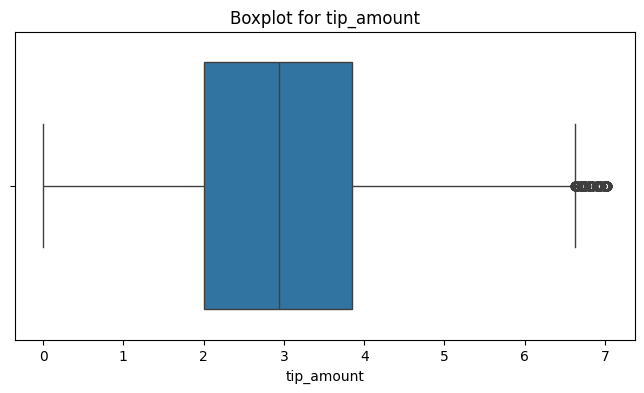

Initial description of tip_amount: count    132722.000000
mean          2.951792
std           1.378531
min           0.000000
25%           2.000000
50%           2.940000
75%           3.850000
max           7.020000
Name: tip_amount, dtype: float64
After outliers, Value counts for column tip_amount :  tip_amount
2.00    10109
1.00     8868
0.00     5193
3.00     5149
2.80     2421
        ...  
3.38        1
5.02        1
2.29        1
3.43        1
2.96        1
Name: count, Length: 566, dtype: int64
Plotting Box plot for column {column}


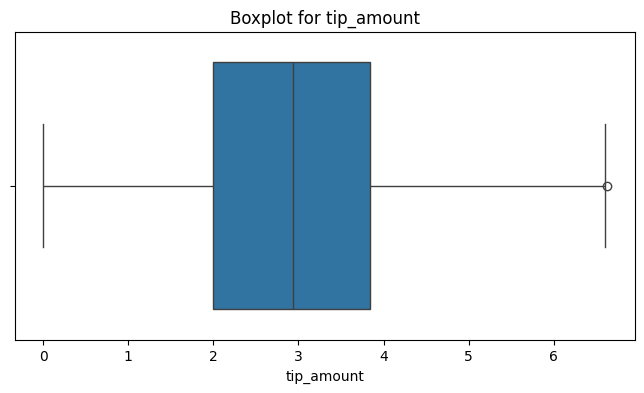

Initial Value counts for column total_amount :  total_amount
16.80    2210
21.00    1961
18.00    1919
12.60    1854
15.96    1627
         ... 
23.45       1
16.04       1
9.14        1
14.83       1
32.56       1
Name: count, Length: 1535, dtype: int64
Removing Outliers from column {column}


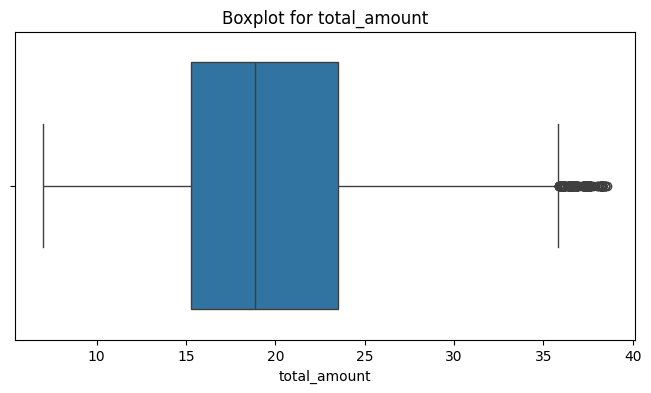

Initial description of total_amount: count    132181.000000
mean         19.774814
std           5.754272
min           7.000000
25%          15.300000
50%          18.840000
75%          23.520000
max          38.540000
Name: total_amount, dtype: float64
After outliers, Value counts for column total_amount :  total_amount
16.80    2210
21.00    1961
18.00    1919
12.60    1854
15.96    1627
         ... 
22.27       1
34.53       1
19.92       1
10.53       1
18.28       1
Name: count, Length: 1480, dtype: int64
Plotting Box plot for column {column}


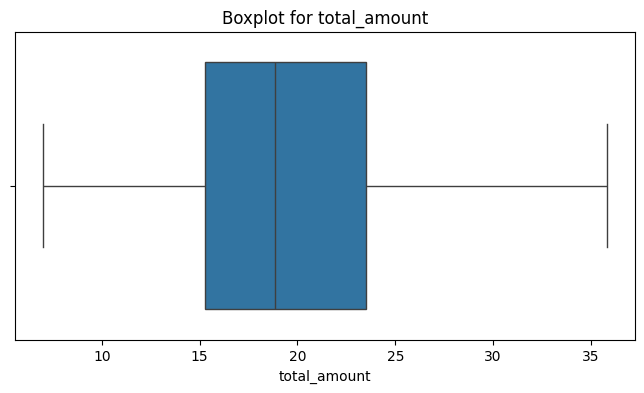

Initial Value counts for column congestion_surcharge :  congestion_surcharge
2.5    131554
Name: count, dtype: int64
Removing Outliers from column {column}


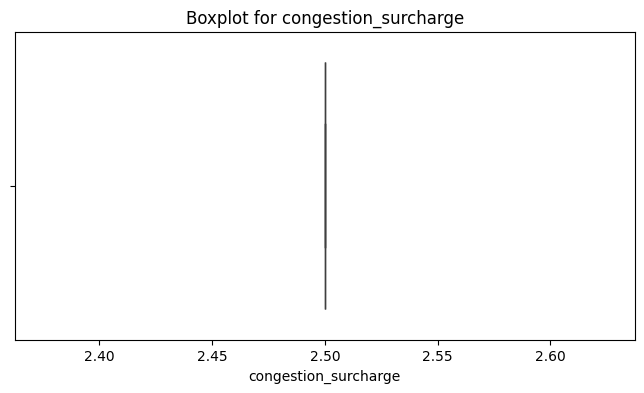

Initial description of congestion_surcharge: count    131554.0
mean          2.5
std           0.0
min           2.5
25%           2.5
50%           2.5
75%           2.5
max           2.5
Name: congestion_surcharge, dtype: float64
After outliers, Value counts for column congestion_surcharge :  congestion_surcharge
2.5    131554
Name: count, dtype: int64
Plotting Box plot for column {column}


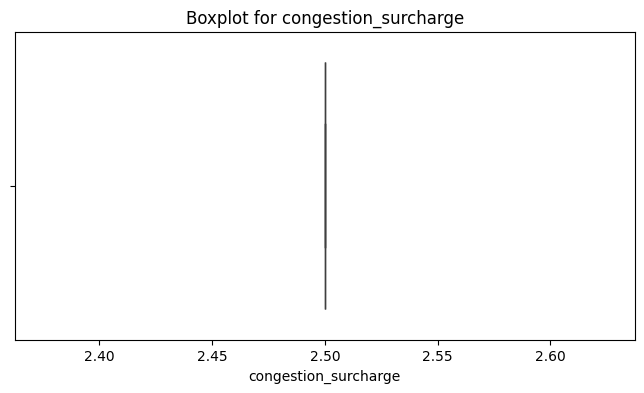

Initial Value counts for column Airport_fee :  Airport_fee
0.0    131554
Name: count, dtype: int64
Removing Outliers from column {column}


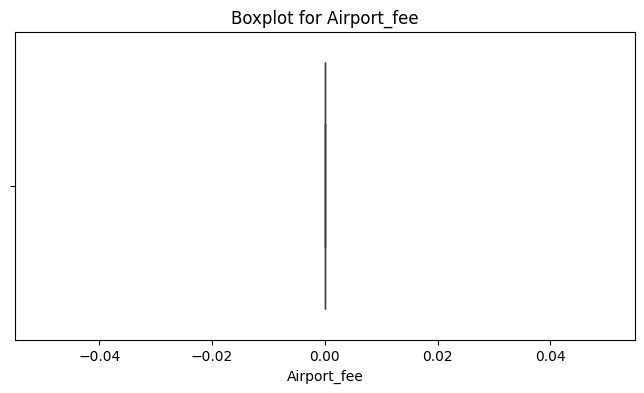

Initial description of Airport_fee: count    131554.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Airport_fee, dtype: float64
After outliers, Value counts for column Airport_fee :  Airport_fee
0.0    131554
Name: count, dtype: int64
Plotting Box plot for column {column}


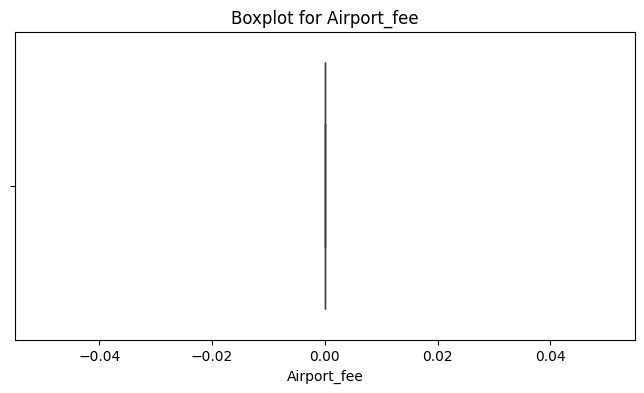

Initial Value counts for column tpep_pickup_hour :  tpep_pickup_hour
8     6649
7     6386
9     6265
19    5992
18    5960
20    5957
11    5798
17    5795
10    5742
21    5619
13    5579
2     5531
22    5527
12    5524
6     5512
1     5475
14    5407
16    5405
15    5281
0     5159
3     5156
23    5103
5     3509
4     3223
Name: count, dtype: int64
Removing Outliers from column {column}


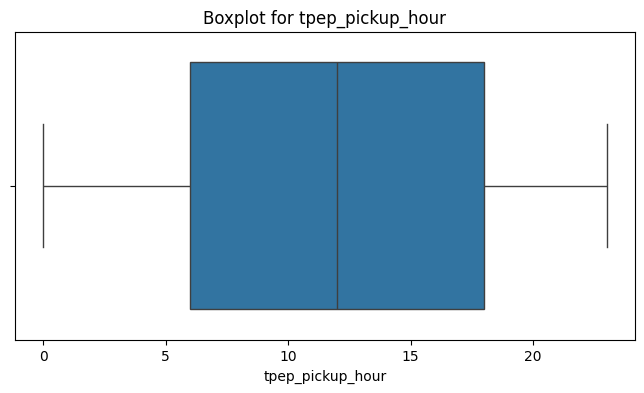

Initial description of tpep_pickup_hour: count    131554.000000
mean         11.759004
std           6.819030
min           0.000000
25%           6.000000
50%          12.000000
75%          18.000000
max          23.000000
Name: tpep_pickup_hour, dtype: float64
After outliers, Value counts for column tpep_pickup_hour :  tpep_pickup_hour
8     6649
7     6386
9     6265
19    5992
18    5960
20    5957
11    5798
17    5795
10    5742
21    5619
13    5579
2     5531
22    5527
12    5524
6     5512
1     5475
14    5407
16    5405
15    5281
0     5159
3     5156
23    5103
5     3509
4     3223
Name: count, dtype: int64
Plotting Box plot for column {column}


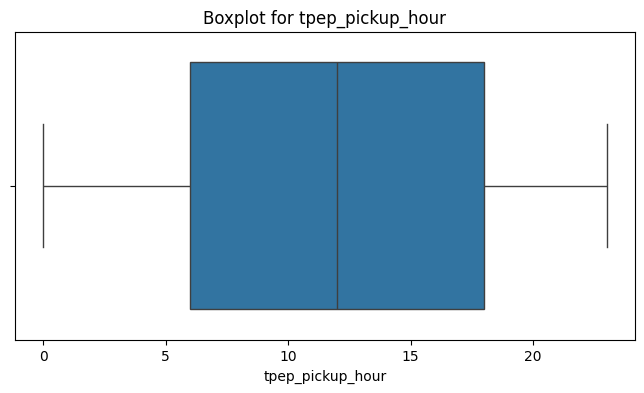

In [ ]:
# Continue with outlier handling

numeric_columns = df.select_dtypes(include='number').columns.tolist()

for column in numeric_columns:
    print(f"Initial Value counts for column {column} : ",df[column].value_counts())
    print("Removing Outliers from column {column}")
    boxplot_column(df, column)
    # Passing "upper" as parameter value, since we specifically want to remove upper outlier which can cause significant distortion in data
    df = remove_outliers(df, column,"upper")
    print(f"After outliers, Value counts for column {column} : ",df[column].value_counts())
    print("Plotting Box plot for column {column}")
    boxplot_column(df, column)


In [ ]:
# Do any columns need standardising?
df.info()
df['tpep_pickup_date'] = pd.to_datetime(df['tpep_pickup_date'])
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 131554 entries, 1 to 296770
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               131554 non-null  int64         
 1   tpep_pickup_datetime   131554 non-null  datetime64[us]
 2   tpep_dropoff_datetime  131554 non-null  datetime64[us]
 3   passenger_count        131554 non-null  float64       
 4   trip_distance          131554 non-null  float64       
 5   RatecodeID             131554 non-null  float64       
 6   PULocationID           131554 non-null  int64         
 7   DOLocationID           131554 non-null  int64         
 8   payment_type           131554 non-null  int64         
 9   fare_amount            131554 non-null  float64       
 10  tip_amount             131554 non-null  float64       
 11  total_amount           131554 non-null  float64       
 12  congestion_surcharge   131554 non-null  float64  

(131554, 16)

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [ ]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'tip_amount',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'tpep_pickup_hour',
 'tpep_pickup_date']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

#### Solution to above problem statement 3.1.1

The below columns represent the respective mentioned categories:

- `VendorID`: **Categorical**  
- `tpep_pickup_datetime`: **Categorical**  
- `tpep_dropoff_datetime`: **Categorical**  
- `passenger_count`: **Numerical**  
- `trip_distance`: **Numerical**  
- `RatecodeID`: **Categorical**  
- `PULocationID`: **Categorical**  
- `DOLocationID`: **Categorical**  
- `payment_type`: **Categorical**  
- `pickup_hour`: **Categorical**  
- `trip_duration`: **Numerical**

### The following monetary parameters belong in the same category. Is it categorical or numerical?

- `fare_amount`  
- `extra`  
- `mta_tax`  
- `tip_amount`  
- `tolls_amount`  
- `improvement_surcharge`  
- `total_amount`  
- `congestion_surcharge`  
- `airport_fee`

    **All the above-mentioned columns represent Numerical values**


##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

tpep_pickup_hour
8     6649
7     6386
9     6265
19    5992
18    5960
20    5957
11    5798
17    5795
10    5742
21    5619
13    5579
2     5531
22    5527
12    5524
6     5512
1     5475
14    5407
16    5405
15    5281
0     5159
3     5156
23    5103
5     3509
4     3223
Name: count, dtype: int64


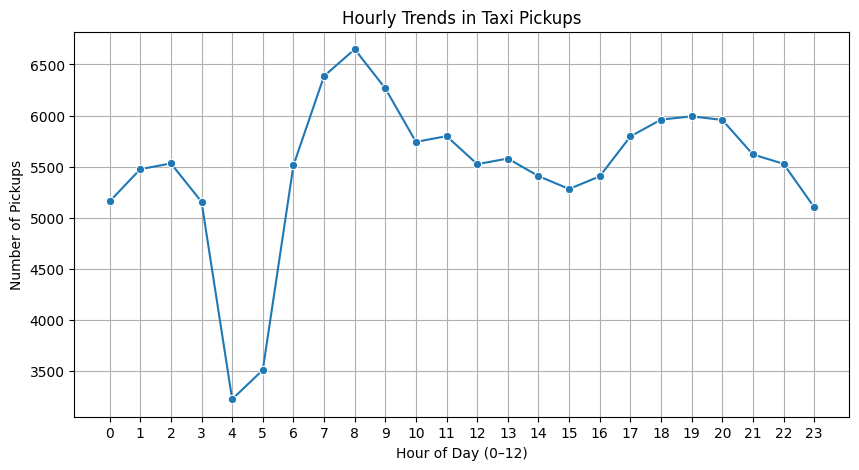

In [ ]:
# Find and show the hourly trends in taxi pickups
hourly_counts = df['tpep_pickup_hour'].value_counts()
print(hourly_counts)

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o')

plt.title('Hourly Trends in Taxi Pickups')
plt.xlabel('Hour of Day (0–12)')
plt.ylabel('Number of Pickups')
plt.xticks(range(0, 24)) 
plt.grid(True)
plt.show()

#Observation : Number of pickups are high are low during 3 a.m to 6 a.m

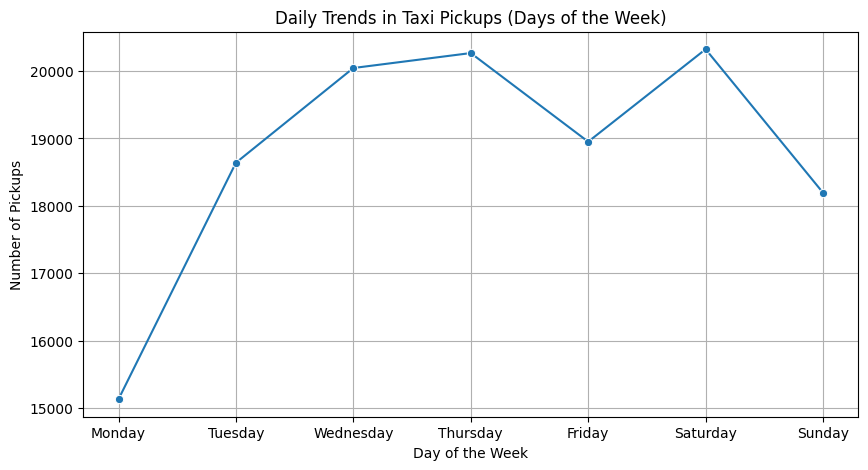

In [ ]:
# Find and show the daily trends in taxi pickups (days of the week)

#Since there is no day column we need to first extract day from date column
df['pickup_day'] = df['tpep_pickup_date'].dt.day_name()

# Need to sort weekdays as it will be sorted on basis of count
daily_counts = df['pickup_day'].value_counts()
daily_counts = daily_counts.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10, 5))
sns.lineplot(x=daily_counts.index, y=daily_counts.values,marker='o')
plt.title('Daily Trends in Taxi Pickups (Days of the Week)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pickups')
plt.grid(True)
plt.show()

#Observation : Number of pickups are high on Wednesday and Thursday and saturday

In [ ]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1          2  2023-09-20 00:29:43   2023-09-20 00:33:59              1.0   
5          2  2023-01-22 00:32:09   2023-01-22 00:53:14              1.0   
6          2  2023-01-27 00:07:45   2023-01-27 00:16:02              1.0   
10         2  2023-11-19 00:22:10   2023-11-19 00:34:18              1.0   
11         1  2023-10-01 00:23:42   2023-10-01 00:33:22              1.0   

    trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
1            0.90         1.0           263           141             1   
5            3.75         1.0            48           141             1   
6            1.51         1.0           234           144             1   
10           1.77         1.0            48           186             1   
11           1.40         1.0           114            68             1   

    fare_amount  tip_amount  total_amount  congestion_surcharge  Airport_fee  \
1           6.5        2.30         13.80                   2.5          0.0   
5          21.9        5.38         32.28                   2.5          0.0   
6          10.0        3.75         18.75                   2.5          0.0   
10         12.1        3.42         20.52                   2.5          0.0   
11         10.7        2.00         17.70                   2.5          0.0   

    tpep_pickup_hour tpep_pickup_date pickup_day  
1                  0       2023-09-20  Wednesday  
5                  0       2023-01-22     Sunday  
6                  0       2023-01-27     Friday  
10                 0       2023-11-19     Sunday  
11                 0       2023-10-01     Sunday

In [ ]:
df1 = df

pickup_month
October      12596
March        12173
May          11773
November     11403
April        11338
June         11268
December     11150
January      10906
February     10404
July          9660
September     9545
August        9338
Name: count, dtype: int64


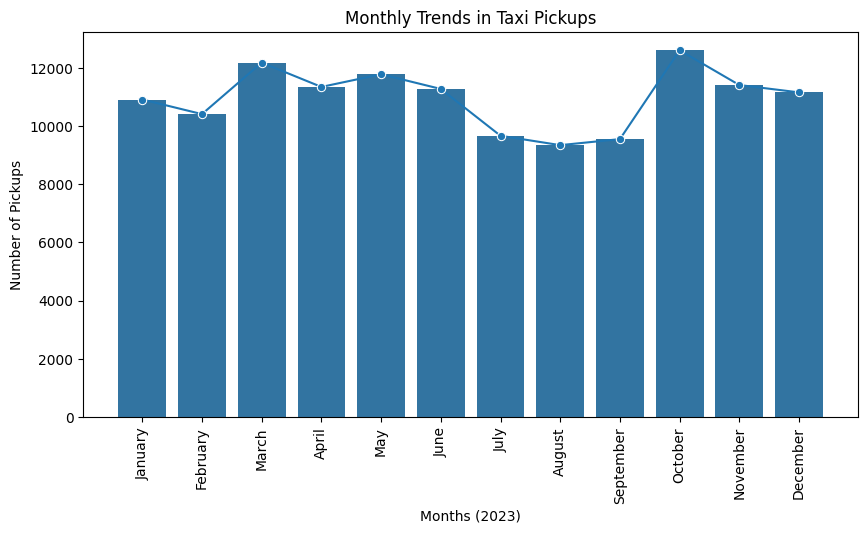

In [ ]:
# Show the monthly trends in pickups


#Since there is no month column we need to first extract month name from date column
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()
print(df['pickup_month'].value_counts())
# Need to sort weekdays as it will be sorted on basis of count
daily_counts = df['pickup_month'].value_counts()

daily_counts.head()

month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
daily_counts = daily_counts.reindex(month_order)

plt.figure(figsize=(10, 5))

# Line plot on top
sns.barplot(x=daily_counts.index, y=daily_counts.values)
sns.lineplot(x=daily_counts.index, y=daily_counts.values, marker='o')

plt.title('Monthly Trends in Taxi Pickups')
plt.xlabel('Months (2023)')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=90) 
plt.show()

# #Observation : There is no major spike in no. of passengers, but it has grown in October

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [ ]:
# Analyse the above parameters

columns_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

print(f"Out of all the mentioned column, below columns have zero or negative values")
for column in columns_check:
    if (df[column] <= 0).any():
        print(f"\nColumn : {column}")
        print(f"Count of zero values: ",(df[column] == 0).sum())
        print(f"Count of negative values: ",(df[column] < 0).sum())       
    # else:
    #     print(f"Column {column} has values greater than 0")

#Observation : These contain zero values


Out of all the mentioned column, below columns have zero or negative values

Column : tip_amount
Count of zero values:  5193
Count of negative values:  0

Column : trip_distance
Count of zero values:  368
Count of negative values:  0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**Observations:**
-    tip_amount : There is a possibility that tip amount can be 0 as every customer may not tip. 
-   trip_distance :  For shorter distance, it is possible that trip is round off to zero or cancelled trip


**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [ ]:
# Create a df with non zero entries for the selected parameters.

# Observations:
#    tip_amount : There is a possibility that tip amount can be 0 as every customer may not tip. 
#    trip_distance :  For shorter distance, it is possible that trip is round off to zero or cancelled trip

print(df.shape)
df = df[~(df['trip_distance'] <= 0)]
print(df.shape)

(131554, 18)
(131186, 18)


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

/tmp/ipykernel_1341114/957284583.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, palette="Blues")


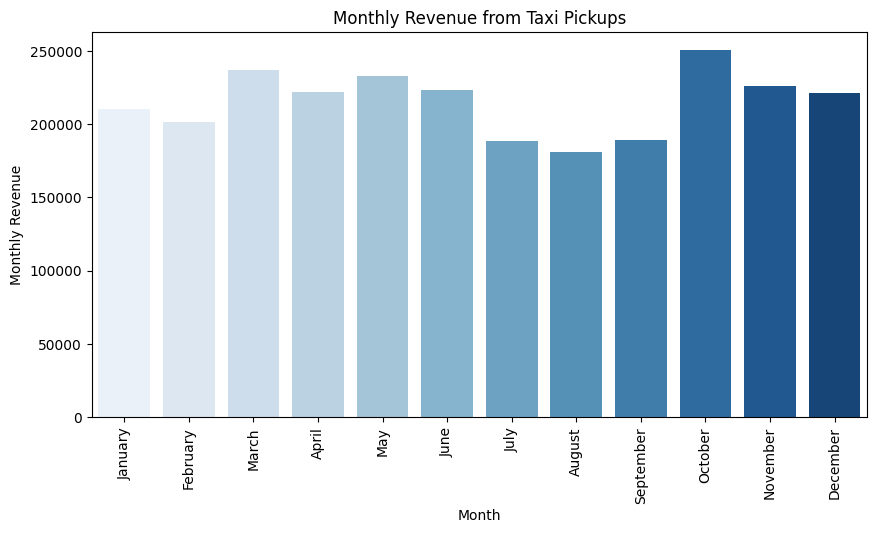

In [ ]:
# Group data by month and analyse monthly revenue


monthly_revenue = df.groupby('pickup_month')['total_amount'].sum()
#print(monthly_revenue)
monthly_revenue = monthly_revenue.reindex(month_order)

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, palette="Blues")
plt.title("Monthly Revenue from Taxi Pickups")
plt.xlabel("Month")
plt.ylabel("Monthly Revenue")
plt.xticks(rotation=90)
plt.show()

#Observation : Revenue is high in the month of October and lowest in August

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [ ]:
# Calculate proportion of each quarter

df['pickup_quarter'] = df['tpep_pickup_datetime'].dt.quarter

quarter_counts = df['pickup_quarter'].value_counts().sort_index()

quarter_proportion = round((quarter_counts / quarter_counts.sum()) * 100, 2)

print("Proportion of Pickups for each quarter as below :")
for quarter, proportion in quarter_proportion.items():
    print(f"Quarter Q{quarter}: {proportion}%")
    
#Observation : The proportion is almost similar except for Q3

Proportion of Pickups for each quarter as below :
Quarter Q1: 25.45%
Quarter Q2: 26.14%
Quarter Q3: 21.7%
Quarter Q4: 26.71%


/tmp/ipykernel_1341114/197137518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pickup_quarter'] = df['tpep_pickup_datetime'].dt.quarter


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

Correlation between trip_distance and fare_amount: 0.86


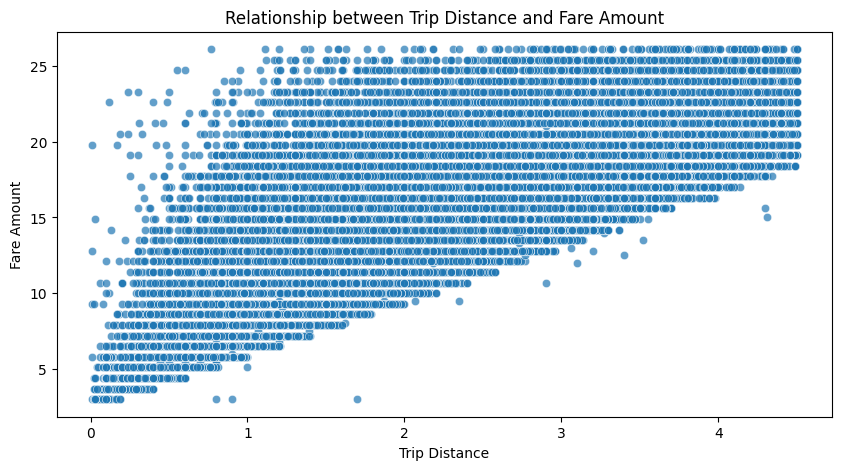

In [ ]:
# Show how trip fare is affected by distance

# Show relationship between fare and trip duration


correlation = df['trip_distance'].corr(df['fare_amount'])
print(f"Correlation between trip_distance and fare_amount: {round(correlation, 2)}")
 
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='trip_distance', y='fare_amount', alpha=0.7)
plt.title('Relationship between Trip Distance and Fare Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

# Observation : As distance increases, fare increases,indicating a strong positive relationship
# Correlation between trip_distance and fare_amount: 0.86


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

/tmp/ipykernel_1341114/1897583192.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60


Correlation between fare_amount and trip_duration: 0.18


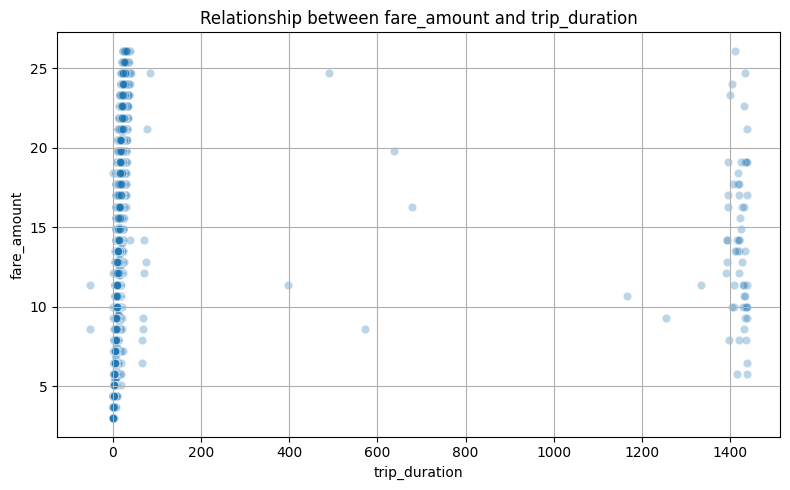

In [ ]:
def correlation_analysis(df,column1,column2):
    # Since there is not column for trip duration, Need to calculate from existing columns
    # Considering duration time in minutes
    # df.loc[:, 'trip_duration'] , to suppress security warning
    
    df.loc[:, 'trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
 
    correlation = df[column1].corr(df[column2])
    print(f"Correlation between {column1} and {column2}: {round(correlation, 2)}")
    
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=column2, y=column1, alpha=0.3)
    plt.title(f'Relationship between {column1} and {column2}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

correlation_analysis(df,'fare_amount','trip_duration')

#Correlation between fare_amount and trip_duration is 0.15, indicating a weak positive relationship
# Fares slightly increase with longer trip durations.


/home/hiteshp/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hiteshp/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation between fare_amount and passenger_count: nan


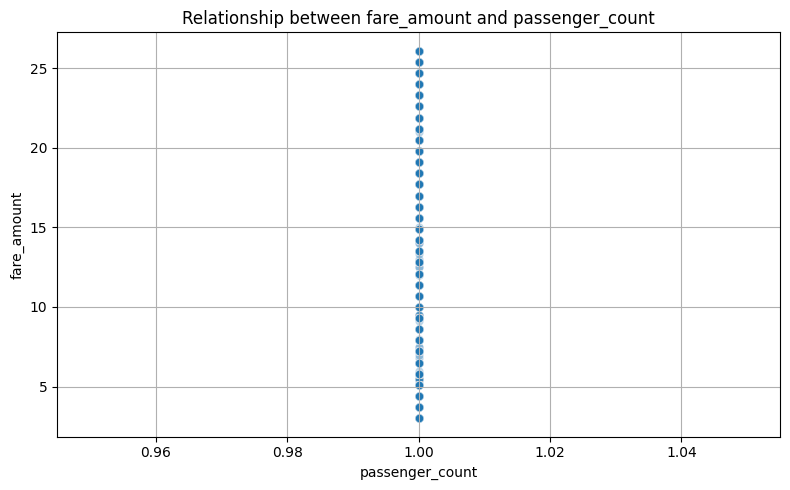

In [ ]:
# Show relationship between fare and number of passengers

correlation_analysis(df,'fare_amount','passenger_count')


Correlation between tip_amount and trip_distance: 0.45


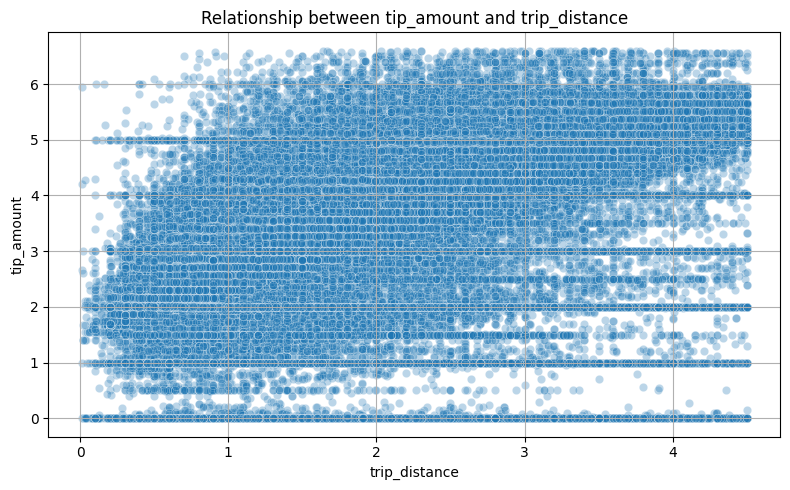

In [ ]:
# Show relationship between tip and trip distance


correlation_analysis(df,'tip_amount','trip_distance')

# Correlation between tip_amount and trip_distance is 0.45, indicating a moderate positive relationship
# Longer trips, receive higher tips.

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [ ]:
# Analyse the distribution of different payment types (payment_type).

# Payment type mapping
payment_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute'
}

df.loc[:,'payment_label'] = df['payment_type'].map(payment_mapping)

payment_counts = df['payment_label'].value_counts()

print("Payment type distribution are as below : \n")
print(payment_counts)



Payment type distribution are as below : 

payment_label
Credit Card    131186
Name: count, dtype: int64


/tmp/ipykernel_1341114/2551614148.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'payment_label'] = df['payment_type'].map(payment_mapping)


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [ ]:
# !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [ ]:
import geopandas as gpd

# Read the shapefile using geopandas
zones = gpd.read_file("/home/hiteshp/Documents/Personal/Upgrad/IITB/EDA_Assignment/Datasets and Dictionary-NYC/taxi_zones/taxi_zones.shp") # read the .shp file using gpd
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

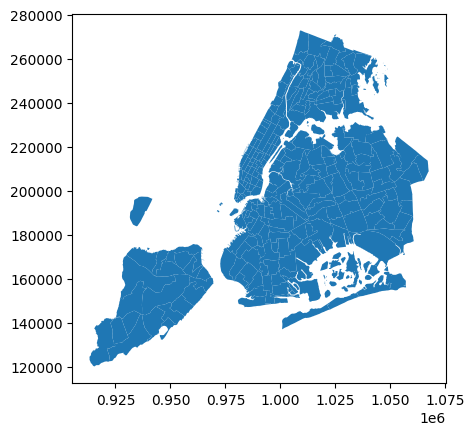

In [ ]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [ ]:
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

In [ ]:
# Merge zones and trip records using locationID and PULocationID

# Temporary pickup zone DataFrame with relevant columns, rename to merge on column
pickup_zones = zones[['LocationID', 'zone']].rename(columns={
    'LocationID': 'PULocationID',
    'zone': 'pickup_zone'
})

print(pickup_zones)

# Merge zones with trip records
df = df.merge(pickup_zones, on='PULocationID', how='left')

# Verify new dataset
print(df[['PULocationID', 'pickup_zone']].head())

     PULocationID              pickup_zone
0               1           Newark Airport
1               2              Jamaica Bay
2               3  Allerton/Pelham Gardens
3               4            Alphabet City
4               5            Arden Heights
..            ...                      ...
258           259       Woodlawn/Wakefield
259           260                 Woodside
260           261       World Trade Center
261           262           Yorkville East
262           263           Yorkville West

[263 rows x 2 columns]
   PULocationID              pickup_zone
0           263           Yorkville West
1            48             Clinton East
2           234                 Union Sq
3            48             Clinton East
4           114  Greenwich Village South


**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [ ]:
# Group data by location and calculate the number of trips

trip_counts = df['pickup_zone'].value_counts().reset_index()

print("Number of trips by location : \n",trip_counts.head())
zones.head()


Number of trips by location : 
                     pickup_zone  count
0         Upper East Side South   6748
1         Upper East Side North   6303
2                Midtown Center   5845
3  Penn Station/Madison Sq West   5687
4                  Midtown East   5204


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [ ]:
# Merge trip counts back to the zones GeoDataFrame


trip_counts.columns = ['zone', 'trip_count']


zones = zones.merge(trip_counts, on='zone', how='left')

zones['trip_count'] = zones['trip_count'].fillna(0).astype(int)


print(zones.head())


   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   trip_count  
0           0  
1           0  
2           0  
3         271  
4           0  


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

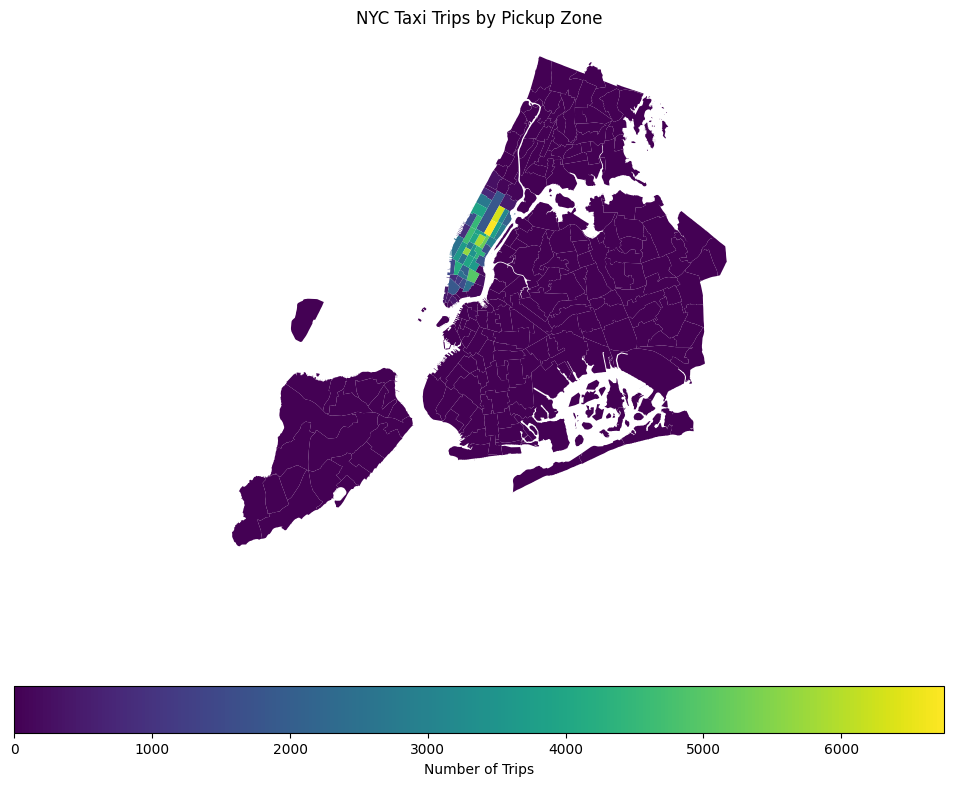

In [ ]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

zones.plot(
    column='trip_count',
    ax=ax,
    legend=True,
    legend_kwds={'label': "Number of Trips", 'orientation': "horizontal"}
)

ax.set_title('NYC Taxi Trips by Pickup Zone')
ax.axis("off") #Does not provide meaningful insight

plt.show()


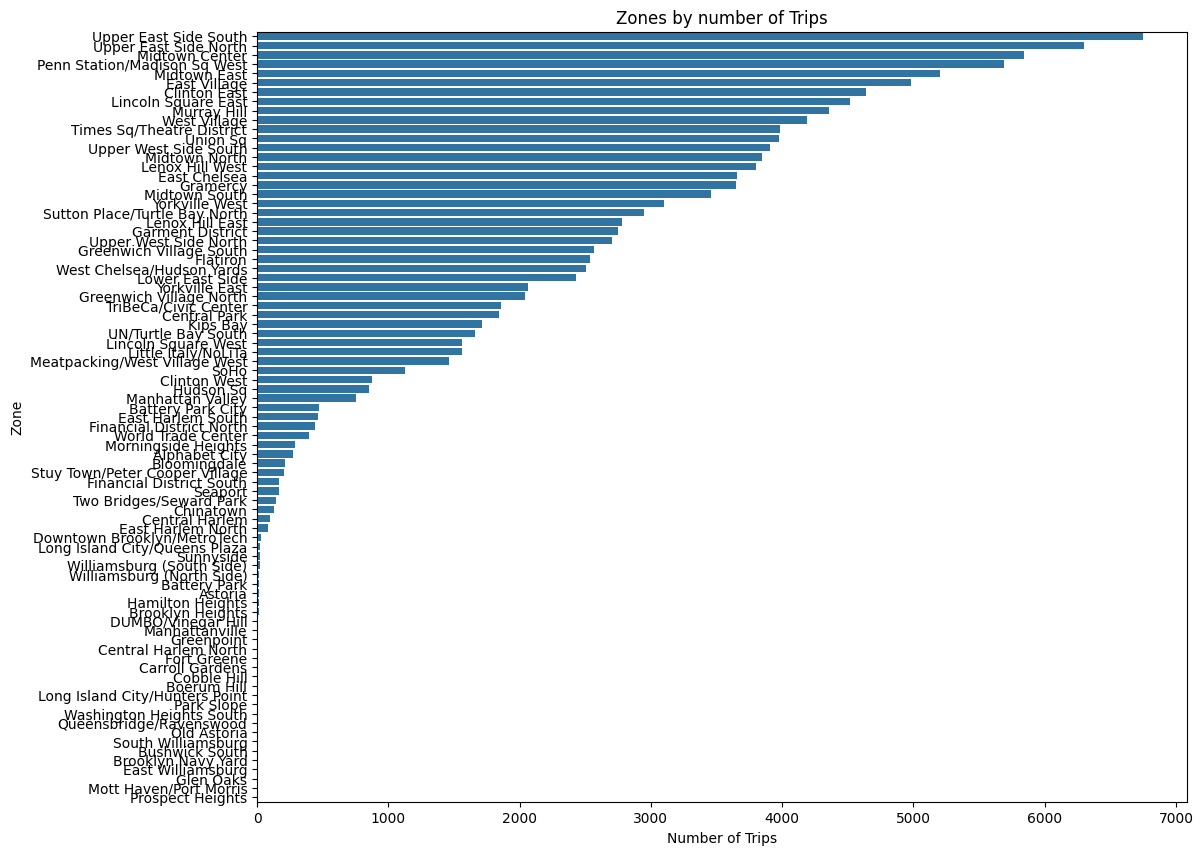

In [ ]:
# can you try displaying the zones DF sorted by the number of trips?
zones_sorted=zones[zones['trip_count']>0]
zones = zones_sorted.sort_values(by='trip_count', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

sns.barplot(x='trip_count', y='zone', data=zones, ax=ax)

ax.set_title('Zones by number of Trips')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Zone')

plt.show()


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [ ]:

zones.head()
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-09-20 00:29:43   2023-09-20 00:33:59              1.0   
1         2  2023-01-22 00:32:09   2023-01-22 00:53:14              1.0   
2         2  2023-01-27 00:07:45   2023-01-27 00:16:02              1.0   
3         2  2023-11-19 00:22:10   2023-11-19 00:34:18              1.0   
4         1  2023-10-01 00:23:42   2023-10-01 00:33:22              1.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0           0.90         1.0           263           141             1   
1           3.75         1.0            48           141             1   
2           1.51         1.0           234           144             1   
3           1.77         1.0            48           186             1   
4           1.40         1.0           114            68             1   

   fare_amount  ...  congestion_surcharge  Airport_fee  tpep_pickup_hour  \
0          6.5  ...                   2.5          0.0                 0   
1         21.9  ...                   2.5          0.0                 0   
2         10.0  ...                   2.5          0.0                 0   
3         12.1  ...                   2.5          0.0                 0   
4         10.7  ...                   2.5          0.0                 0   

   tpep_pickup_date  pickup_day pickup_month pickup_quarter trip_duration  \
0        2023-09-20   Wednesday    September              3      4.266667   
1        2023-01-22      Sunday      January              1     21.083333   
2        2023-01-27      Friday      January              1      8.283333   
3        2023-11-19      Sunday     November              4     12.133333   
4        2023-10-01      Sunday      October              4      9.666667   

   payment_label              pickup_zone  
0    Credit Card           Yorkville West  
1    Credit Card             Clinton East  
2    Credit Card                 Union Sq  
3    Credit Card             Clinton East  
4    Credit Card  Greenwich Village South  

[5 rows x 22 columns]

In [ ]:
# Find routes which have the slowest speeds at different times of the day

dropoff_zones = zones[['LocationID', 'zone']].rename(columns={
    'LocationID': 'DOLocationID',
    'zone': 'dropoff_zone'
})

df = df.merge(dropoff_zones, on='DOLocationID', how='left')

# Since there is no route column we first create 'route' and convert trip_duration to hours for grouping 
df['route'] = df['pickup_zone'] + ' from ' + df['dropoff_zone']

# duration is in minutes, conveerting to hours
df['trip_duration_hours'] = df['trip_duration'] / 60 
df = df[(df['trip_distance'] > 0) & (df['trip_duration_hours'] > 0)]

# Calculate average duration per route per hour
avg_duration = df.groupby(['route', 'tpep_pickup_hour'])['trip_duration_hours'].mean().reset_index()
#print("Avg Duration : \n",avg_duration)

# Calculate average distance per route
avg_distance = df.groupby('route')['trip_distance'].mean().reset_index()
#print("Avg Distance : \n",avg_distance)

# Merge both 
route_speed = avg_duration.merge(avg_distance, on='route')
#print("Route speed : \n",route_speed)

# Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)
route_speed['average_speed'] = route_speed['trip_distance'] / route_speed['trip_duration_hours']
#print("Route speed : \n",route_speed)

# Get slowest route per hour
slowest_routes_hour = route_speed.sort_values(by='average_speed').groupby('tpep_pickup_hour').first().reset_index()

# Step 7: Display
print("Slowest Routes bat different times of the day (Hourly) :\n")
print(slowest_routes_hour[['tpep_pickup_hour', 'route', 'average_speed']])

Slowest Routes bat different times of the day (Hourly) :

    tpep_pickup_hour                                              route  \
0                  0                    Midtown South from Midtown East   
1                  1              Greenwich Village North from Union Sq   
2                  2          Little Italy/NoLiTa from Garment District   
3                  3                  Flatiron from UN/Turtle Bay South   
4                  4                     Midtown East from Midtown East   
5                  5  West Chelsea/Hudson Yards from West Chelsea/Hu...   
6                  6  Times Sq/Theatre District from Upper East Side...   
7                  7          Midtown Center from Upper West Side North   
8                  8    Penn Station/Madison Sq West from Midtown North   
9                  9       Upper East Side South from East Harlem South   
10                10         Lenox Hill East from Upper East Side North   
11                11            Clinton We

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

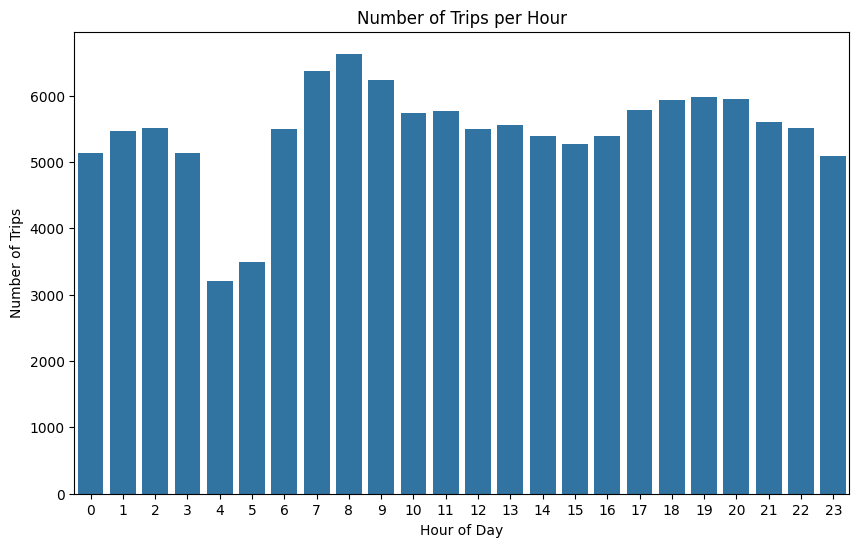

Busiest Hour is 8 with 6632 trips


In [ ]:
# Visualise the number of trips per hour and find the busiest hour


# Count trips by pickup hour
hourly_trip_counts = df['tpep_pickup_hour'].value_counts().sort_index()


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x=hourly_trip_counts.index, y=hourly_trip_counts.values, ax=ax)

ax.set_title('Number of Trips per Hour')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Trips')
plt.show()

busiest_hour = hourly_trip_counts.idxmax()
busiest_hour_count = hourly_trip_counts.max()

print(f"Busiest Hour is {busiest_hour} with {busiest_hour_count} trips")

# Observation :  Bussiest hour is 8 a.m

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

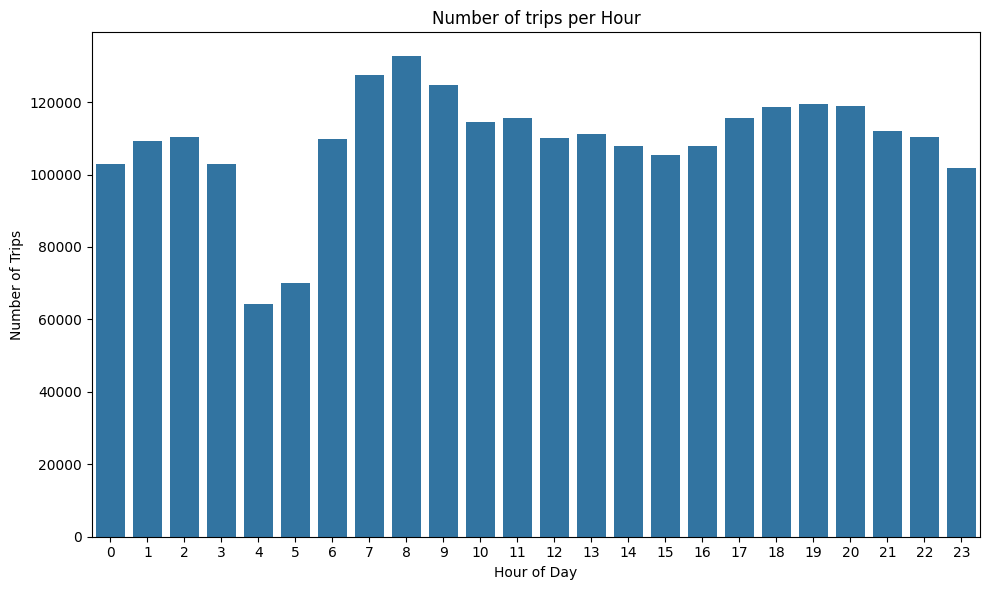

In [ ]:
# Scale up the number of trips
sample_fraction = 0.05 

hourly_trip_sampled = df['tpep_pickup_hour'].value_counts().sort_index()

# print(hourly_trip_sampled)

hourly_trip_sampled = (hourly_trip_sampled / sample_fraction).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x=hourly_trip_sampled.index, y=hourly_trip_sampled.values, ax=ax)

ax.set_title('Number of trips per Hour')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Trips')
plt.tight_layout()
plt.show()



**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

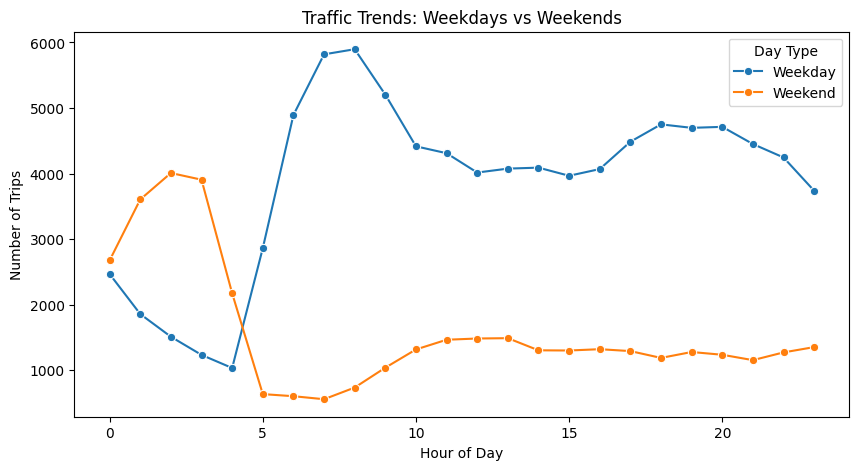

In [ ]:
# Compare traffic trends for the week days and weekends

# df.head()

# Create a new column for weekdays/weekends
df['pickup_day_type'] = df['pickup_day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Group by hour and day type
traffic_trends = df.groupby(['tpep_pickup_hour', 'pickup_day_type']).size().reset_index(name='trip_count')

plt.figure(figsize=(10, 5))
sns.lineplot(data=traffic_trends, x='tpep_pickup_hour', y='trip_count', hue='pickup_day_type', marker='o')

plt.title('Traffic Trends: Weekdays vs Weekends')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend(title='Day Type')
plt.show()

# Observation : Traffic is high on weekends especially at morning hours


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [ ]:
# Find top 10 pickup and dropoff zones

print("Top 10 pickup zone : \n",df['pickup_zone'].value_counts().head(10))

print("\nTop 10 dropoff zone : \n",df['dropoff_zone'].value_counts().head(10))



Top 10 pickup zone : 
 pickup_zone
Upper East Side South           6748
Upper East Side North           6303
Midtown Center                  5845
Penn Station/Madison Sq West    5687
Midtown East                    5204
East Village                    4981
Clinton East                    4641
Lincoln Square East             4517
Murray Hill                     4360
West Village                    4190
Name: count, dtype: int64

Top 10 dropoff zone : 
 dropoff_zone
Midtown Center           6340
Upper East Side North    6222
Upper East Side South    6210
Murray Hill              4840
Midtown East             4612
East Chelsea             4110
Lenox Hill West          4036
Lincoln Square East      3961
Upper West Side South    3819
Union Sq                 3764
Name: count, dtype: int64


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [ ]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Since we do not have dedicated zone column, we first calculate pickup and dropoff counts per zone
pickup_counts = df['pickup_zone'].value_counts().reset_index()
pickup_counts.columns = ['zone', 'pickup_count']

dropoff_counts = df['dropoff_zone'].value_counts().reset_index()
dropoff_counts.columns = ['zone', 'dropoff_count']

# Merge pickup and dropoff counts on the basis of zone, we do outer  join as some zones might have only pickups or only dropoff
zone_counts = pd.merge(pickup_counts, dropoff_counts, on='zone', how='outer').fillna(0)

# Calculate pickup/dropoff ratio
zone_counts['pickup_dropoff_ratio'] = round(zone_counts['pickup_count'] / zone_counts['dropoff_count'],2)

# Sort and display top 10 and bottom 10 ratios
top_10 = zone_counts.sort_values(by='pickup_dropoff_ratio', ascending=False).head(10)
bottom_10 = zone_counts.sort_values(by='pickup_dropoff_ratio').head(10)

print("Top 10 zones by pickup/dropoff ratios: \n",top_10[['zone', 'pickup_count', 'dropoff_count', 'pickup_dropoff_ratio']])
print("\nBottom 10 zones by pickup/dropoff ratios: \n",bottom_10[['zone', 'pickup_count', 'dropoff_count', 'pickup_dropoff_ratio']])



Top 10 zones by pickup/dropoff ratios: 
                             zone  pickup_count  dropoff_count  \
57  Penn Station/Madison Sq West          5687           3247   
33       Greenwich Village South          2564           1499   
44               Lower East Side          2431           1509   
77                  West Village          4190           2680   
28              Garment District          2746           1836   
22                  East Village          4981           3450   
14                  Clinton East          4641           3592   
12                  Central Park          1843           1514   
51                 Midtown South          3459           2871   
41           Little Italy/NoLiTa          1560           1318   

    pickup_dropoff_ratio  
57                  1.75  
33                  1.71  
44                  1.61  
77                  1.56  
28                  1.50  
22                  1.44  
14                  1.29  
12                  1.22  


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [ ]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Filter data for night hours (11PM to 5AM)
night_df = df[(df['tpep_pickup_hour'] > 23) | (df['tpep_pickup_hour'] < 5)]

# Since we do not have dedicated zone column, we first calculate pickup and dropoff counts per zone
night_pickup = night_df['pickup_zone'].value_counts().reset_index()
night_pickup.columns = ['zone', 'pickup_count']

night_dropoff = night_df['dropoff_zone'].value_counts().reset_index()
night_dropoff.columns = ['zone', 'dropoff_count']

# Get top 10 pickup and dropoff zones
top_night_pickup = night_pickup.head(10)
top_night_dropoff = night_dropoff.head(10)

print("Top 10 Pickup zones during night hours (11pm to 5am): \n",top_night_pickup)
print("Top 10 Dropoff zones during night hours (11pm to 5am): \n",top_night_dropoff)


Top 10 Pickup zones during night hours (11pm to 5am): 
                         zone  pickup_count
0               East Village          2718
1               West Village          1859
2            Lower East Side          1784
3               Clinton East          1446
4    Greenwich Village South          1350
5                   Gramercy           838
6  West Chelsea/Hudson Yards           809
7        Little Italy/NoLiTa           809
8               East Chelsea           805
9              Midtown South           794
Top 10 Dropoff zones during night hours (11pm to 5am): 
                             zone  dropoff_count
0                   East Village           1379
1                   Clinton East           1130
2                    Murray Hill           1006
3                       Gramercy            936
4                   East Chelsea            872
5                   West Village            796
6                       Flatiron            745
7                       Kips B

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [ ]:
# Filter for night hours (11 PM to 5 AM)

# Filter data for day hours (5AM to 11PM)

day_df = df[(df['tpep_pickup_hour'] >= 5) | (df['tpep_pickup_hour'] <= 23)]

# Calculating total revenue
total_revenue = df['total_amount'].sum()

# Calculating night revenue
night_revenue = night_df.fare_amount.sum()

# Calculating day revenue
day_revenue = day_df.fare_amount.sum()

# Calculate revenue share for nighttime and daytime hours. 
night_share = round((night_revenue / total_revenue) * 100, 2)
day_share = round((day_revenue / total_revenue) * 100, 2)

# Display results
print(f"Nighttime revenue share (11PM - 5AM): {night_share}% , Reveune: {night_revenue} ")
print(f"Daytime revenue share (6AM - 10PM): {day_share}% , Reveune: {day_revenue}")

Nighttime revenue share (11PM - 5AM): 11.11% , Reveune: 287045.9 
Daytime revenue share (6AM - 10PM): 61.2% , Reveune: 1581841.45


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [ ]:
# Analyse the fare per mile per passenger for different passenger counts

# print("Trip Distance ",df['trip_distance'].value_counts())

# Calculate fare per mile per passenger
df['fare_per_mile_per_passenger'] = df['fare_amount'] / (df['trip_distance'] * df['passenger_count'])

# Group by passenger count and calculate average fare per mile per passenger
fare_stats = df.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index().round(2)

print("The fare per mile per passenger for different passenger counts : \n ",fare_stats)


The fare per mile per passenger for different passenger counts : 
     passenger_count  fare_per_mile_per_passenger
0              1.0                         8.14


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [ ]:
# Compare the average fare per mile for different days and for different times of the day

# Calculate fare per mile
df['fare_per_mile'] = df['fare_amount'] / (df['trip_distance'])

# Group by day of the week and calculate average fare per mile
avg_fare_per_mile_day = df.groupby('pickup_day')['fare_per_mile'].mean().reset_index().round(2)

# Group by pickup hour and calculate average fare per mile
avg_fare_per_mile_hour = df.groupby('tpep_pickup_hour')['fare_per_mile'].mean().reset_index().round(2)

# # Display the stats
print("The average fare per mile for different days: \n ",avg_fare_per_mile_day)
print("The average fare per mile for different times of day: \n ",avg_fare_per_mile_hour)




The average fare per mile for different days: 
    pickup_day  fare_per_mile
0     Friday           8.20
1     Monday           8.04
2   Saturday           7.72
3     Sunday           7.51
4   Thursday           8.47
5    Tuesday           8.50
6  Wednesday           8.47
The average fare per mile for different times of day: 
      tpep_pickup_hour  fare_per_mile
0                  0           7.05
1                  1           7.11
2                  2           6.82
3                  3           6.77
4                  4           6.53
5                  5           6.66
6                  6           6.85
7                  7           7.46
8                  8           8.26
9                  9           8.74
10                10           8.91
11                11           9.43
12                12           9.39
13                13           9.24
14                14           9.40
15                15           9.61
16                16           9.14
17                17  

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [ ]:
# Compare fare per mile for different vendors
# Calculate fare per mile

# Group by VendorID and calculate average fare per mile
avg_fare_per_mile_day = df.groupby('VendorID')['fare_per_mile'].mean().reset_index().round(2)

# # Display the stats
print("The average fare per mile for different vendors: \n ",avg_fare_per_mile_day)


The average fare per mile for different vendors: 
     VendorID  fare_per_mile
0         1           8.10
1         2           8.15


**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [ ]:
# Defining distance tiers

# Calculate distance_tier on basis of trip_distance
df['distance_tier'] = df['trip_distance'].apply(lambda x: '0-2 miles' if x <= 2 else ('2-5 miles' if x <= 5 else '5+ miles'))
#df[['trip_distance', 'distance_tier']]

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

Average tip percentage  based on distances : 
   distance_tier  tip_percentage
0     0-2 miles           27.50
1     2-5 miles           21.88
Average tip percentage  based on passenger counts : 
    passenger_count  tip_percentage
0              1.0           25.75
Average tip percentage  based on pickup times : 
     tpep_pickup_hour  tip_percentage
0                  0           25.68
1                  1           25.35
2                  2           25.17
3                  3           25.14
4                  4           25.28
5                  5           26.88
6                  6           25.00
7                  7           24.77
8                  8           24.66
9                  9           25.22
10                10           25.40
11                11           25.28
12                12           25.10
13                13           25.20
14                14           25.07
15                15           24.96
16                16           27.18
17               

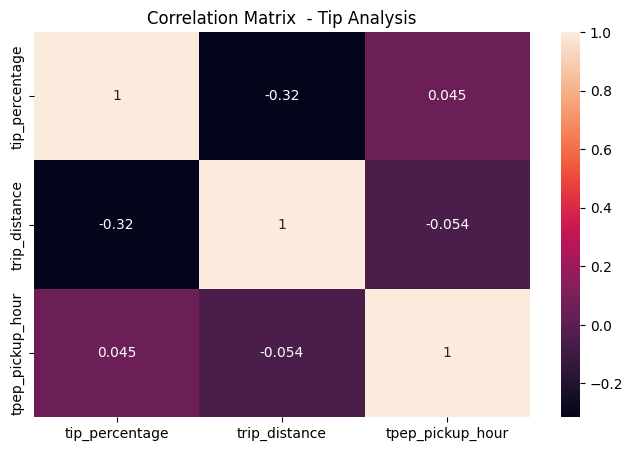

In [ ]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

# print(df.columns)

# Calculate tip percentage
df['tip_percentage'] = (df['tip_amount']/df['fare_amount'])*100

tip_by_distance = df.groupby('distance_tier')['tip_percentage'].mean().reset_index().round(2)
print(f"Average tip percentage  based on distances : \n {tip_by_distance}")

tip_by_passenger_count= df.groupby('passenger_count')['tip_percentage'].mean().reset_index().round(2)
print(f"Average tip percentage  based on passenger counts : \n {tip_by_passenger_count}")

tip_by_pickup_hour = df.groupby('tpep_pickup_hour')['tip_percentage'].mean().reset_index().round(2)
print(f"Average tip percentage  based on pickup times : \n {tip_by_pickup_hour}")


# Since passenger counts is mostly 1, skipping that column as there is no variance
corr_df = df[['tip_percentage', 'trip_distance', 'tpep_pickup_hour']]

# Compute correlation matrix
correlations = corr_df.corr()

# Display correlation of each feature with tip_percentage
print("Correlation with tip_percentage:\n", correlations['tip_percentage'])

plt.figure(figsize=(8, 5))
sns.heatmap(correlations, annot=True)
plt.title('Correlation Matrix  - Tip Analysis')
plt.show()

# Observation
# Factors lead to low tip percentages
    # Longer trips tend to have lower tip percentages. Since the fare may be high passengers tend to pay smaller tips.
    

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

Trips with Tip Percentage < 10%
   Average Trip Distance: 1.99 miles
   Average Pickup Hour: 10.71
   Average Fare Amount: $13.67

Trips with Tip Percentage > 25%
   Average Trip Distance: 1.50 miles
   Average Pickup Hour: 11.90
   Average Fare Amount: $10.80


/tmp/ipykernel_1341114/3635866475.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=trip_distances, palette="Blues")
/tmp/ipykernel_1341114/3635866475.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=pickup_hours, palette="Greens")
/tmp/ipykernel_1341114/3635866475.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=fare_amounts, palette="Reds")


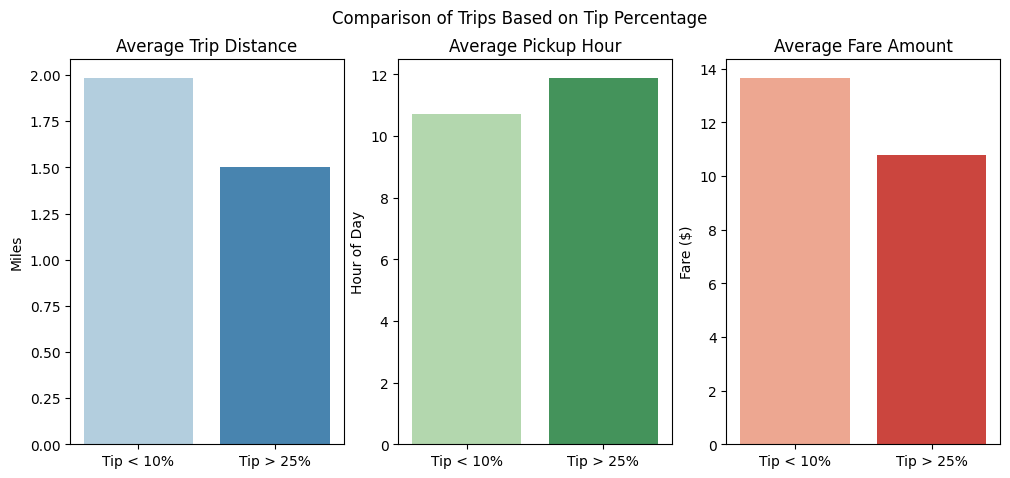

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

# Calculate tip percentage

df_tip_percentage_less_than_10= df[df['tip_percentage'] < 10]
df_tip_percentage_greater_than_25 = df[df['tip_percentage'] > 25]


# Calculate average values for trips with tip percentage < 10
less_than_10_trip_distance = df_tip_percentage_less_than_10['trip_distance'].mean()
less_than_10_pickup_hour = df_tip_percentage_less_than_10['tpep_pickup_hour'].mean()
less_than_10_fare_amount = df_tip_percentage_less_than_10['fare_amount'].mean()
less_than_10_total_amount = df_tip_percentage_less_than_10['total_amount'].mean()

# Calculate average values for trips with tip percentage > 25
greater_than_25_trip_distance = df_tip_percentage_greater_than_25['trip_distance'].mean()
greater_than_25_pickup_hour = df_tip_percentage_greater_than_25['tpep_pickup_hour'].mean()
greater_than_25_fare_amount = df_tip_percentage_greater_than_25['fare_amount'].mean()
greater_than_25_total_amount = df_tip_percentage_greater_than_25['total_amount'].mean()

# Print comparison results
print("Trips with Tip Percentage < 10%")
print(f"   Average Trip Distance: {less_than_10_trip_distance:.2f} miles")
print(f"   Average Pickup Hour: {less_than_10_pickup_hour:.2f}")
print(f"   Average Fare Amount: ${less_than_10_fare_amount:.2f}")

print("\nTrips with Tip Percentage > 25%")
print(f"   Average Trip Distance: {greater_than_25_trip_distance:.2f} miles")
print(f"   Average Pickup Hour: {greater_than_25_pickup_hour:.2f}")
print(f"   Average Fare Amount: ${greater_than_25_fare_amount:.2f}")

# Data for plotting
categories = ["Tip < 10%", "Tip > 25%"]
trip_distances = [less_than_10_trip_distance, greater_than_25_trip_distance]
pickup_hours = [less_than_10_pickup_hour, greater_than_25_pickup_hour]
fare_amounts = [less_than_10_fare_amount, greater_than_25_fare_amount]

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=categories, y=trip_distances, palette="Blues")
plt.title("Average Trip Distance")
plt.ylabel("Miles")

plt.subplot(1, 3, 2)
sns.barplot(x=categories, y=pickup_hours, palette="Greens")
plt.title("Average Pickup Hour")
plt.ylabel("Hour of Day")

plt.subplot(1, 3, 3)
sns.barplot(x=categories, y=fare_amounts, palette="Reds")
plt.title("Average Fare Amount")
plt.ylabel("Fare ($)")

plt.suptitle("Comparison of Trips Based on Tip Percentage")
plt.show()

# Observation : Shorter trips tend to receive higher tips, despite having lower fare amounts.

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

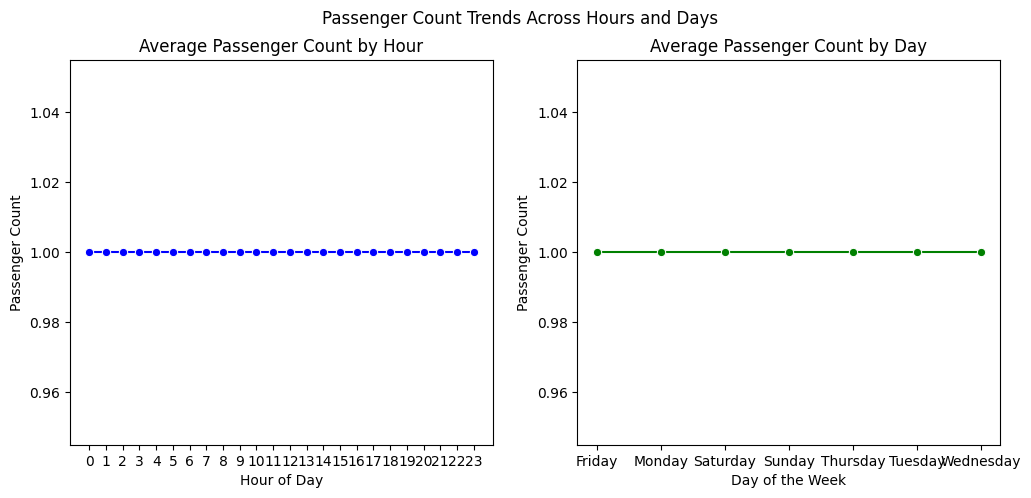

In [ ]:
# See how passenger count varies across hours and days

# Calculate average passenger count by Day and Hour
passenger_by_hour = df.groupby('tpep_pickup_hour')['passenger_count'].mean().reset_index()
passenger_by_day = df.groupby('pickup_day')['passenger_count'].mean().reset_index()


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=passenger_by_hour, x='tpep_pickup_hour', y='passenger_count', marker='o', color='b')
plt.title("Average Passenger Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Passenger Count")
plt.xticks(range(0, 24))

plt.subplot(1, 2, 2)
sns.lineplot(data=passenger_by_day, x='pickup_day', y='passenger_count', marker='o', color='g')
plt.title("Average Passenger Count by Day")
plt.xlabel("Day of the Week")
plt.ylabel("Passenger Count")

plt.suptitle("Passenger Count Trends Across Hours and Days")
plt.show()

#Observation : Passenger count is almost stagnant at 1.

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

/tmp/ipykernel_1341114/3464138112.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pickup_zone_passenger_count, x='passenger_count', y='pickup_zone', palette="Blues")
/tmp/ipykernel_1341114/3464138112.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dropoff_zone_passenger_count, x='passenger_count', y='dropoff_zone', palette="Greens")


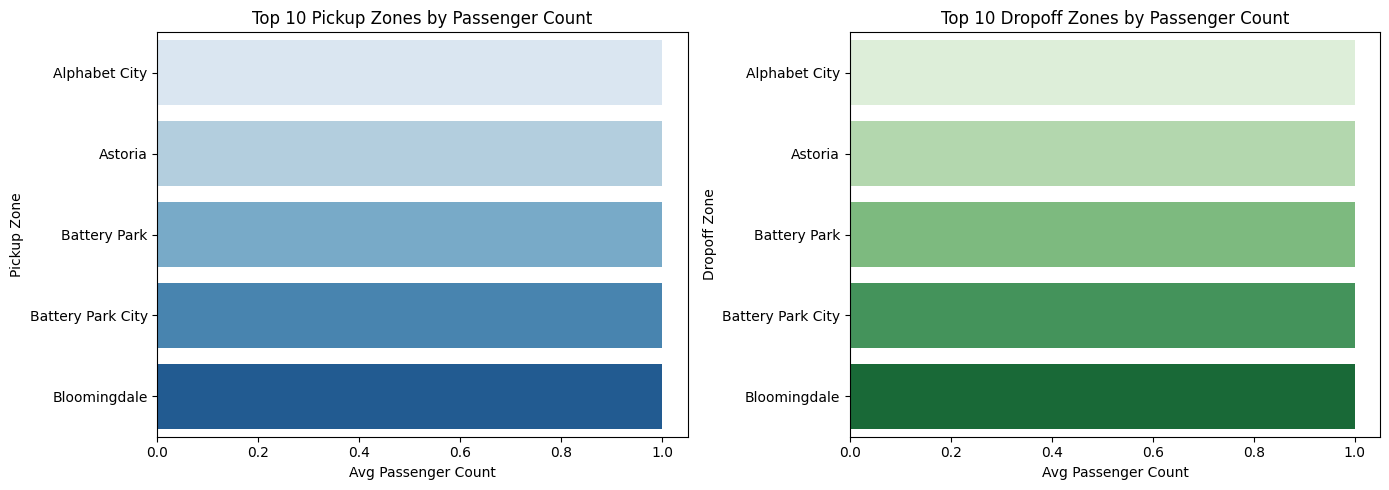

In [ ]:
# How does passenger count vary across zones

# Group by pickup and dropofff zone and calculate the average passenger count
pickup_zone_passenger_count = df.groupby('pickup_zone')['passenger_count'].mean().reset_index().head()
dropoff_zone_passenger_count = df.groupby('dropoff_zone')['passenger_count'].mean().reset_index().head()

# print("Top Pickup Zones by Passenger Count:\n", pickup_zone_passenger_count.head())
# print("Top Dropoff Zones by Passenger Count:\n", dropoff_zone_passenger_count.head())

plt.figure(figsize=(14, 5))

# Pickup Zones
plt.subplot(1, 2, 1)
sns.barplot(data=pickup_zone_passenger_count, x='passenger_count', y='pickup_zone', palette="Blues")
plt.title("Top 10 Pickup Zones by Passenger Count")
plt.xlabel("Avg Passenger Count")
plt.ylabel("Pickup Zone")

# Dropoff Zones
plt.subplot(1, 2, 2)
sns.barplot(data=dropoff_zone_passenger_count, x='passenger_count', y='dropoff_zone', palette="Greens")
plt.title("Top 10 Dropoff Zones by Passenger Count")
plt.xlabel("Avg Passenger Count")
plt.ylabel("Dropoff Zone")

plt.tight_layout()
plt.show()

#Observation : Passenger count is almost stagnant at 1.


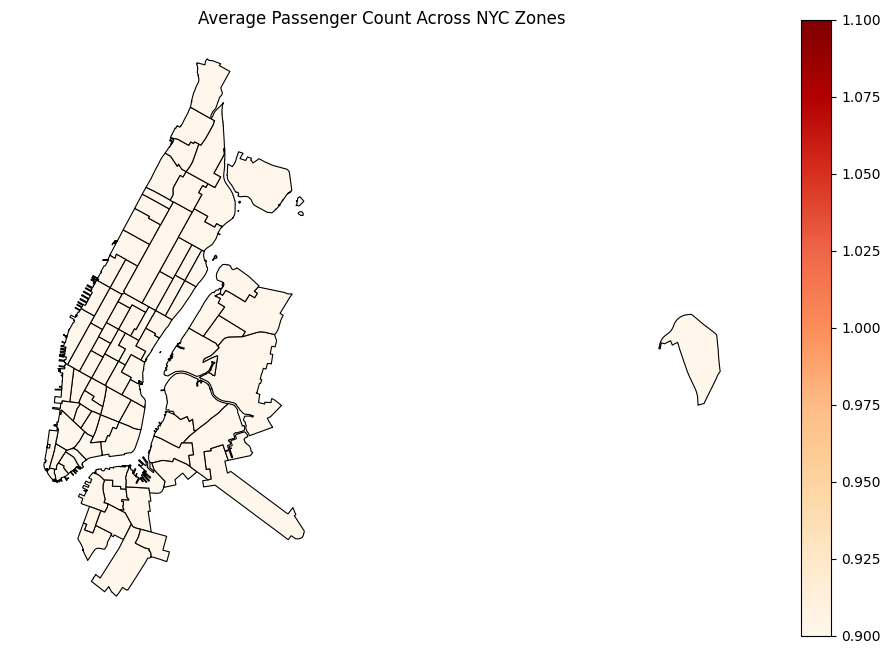

In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Group by pickup zone (LocationID) and calculate average passenger count
avg_passenger_per_zone = df.groupby('PULocationID')['passenger_count'].mean().reset_index()

# Rename column to match zones DataFrame
avg_passenger_per_zone.rename(columns={'PULocationID': 'LocationID'}, inplace=True)

# Merge with zones DataFrame
zones_with_trips = zones.merge(avg_passenger_per_zone, on='LocationID', how='left')

fig, ax = plt.subplots(figsize=(12, 8))
zones_with_trips.plot(column='passenger_count', cmap='OrRd', linewidth=0.8, edgecolor='black', legend=True, ax=ax)

plt.title("Average Passenger Count Across NYC Zones")
plt.axis("off")
plt.show()

# print(zones_with_trips)

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [ ]:
# How often is each surcharge applied?

# Count occurrences of different congestion surcharge values
congestion_counts = df['congestion_surcharge'].value_counts()

# Display results
print("Congestion Surcharge Frequency:")
print(congestion_counts)



# Conclusion : Most of the trips has surcharges applied of $2.5

Congestion Surcharge Frequency:
congestion_surcharge
2.5    131183
Name: count, dtype: int64


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
# Boost cabs availability on Wednesdays, Thursdays, and Saturdays because of high demand.

# Send more cabs during peak hours for work commutes.

# Assign more cabs for shorter trips, as they generate higher tips.

# Employ real-time demand monitoring to dynamically reassign idle cabs.

SyntaxError: invalid syntax (443539613.py, line 1)

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [ ]:
# Place cabs Speicific zones where demand is usually high.

# Assign more vehicles to zones with high weekend activity.

# Rotate vehicles to low-demand zones during off-peak hours for efficiency.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [ ]:
# Introduce dynamic pricing during peak hours to balance demand and availability.

# Offer discounts in Q3 (low-demand period) to attract more riders.

# Implement zone-based pricing, charging more in high-demand areas.
